# Breast Cancer Detection

## Introduction

Breast cancer is cancer that affects both men and women but affects its last 100 times more. According to Wikipedia [[0]](#ref0), **breast cancer** is the most common type of cancer in women globally, with 25% of all women cancer cases. In 2018, 2 million new cases were diagnosed, and 627,000 deaths were deplored.<br>

After the detection of the lump, a first prognosis can be by physical examination and mammography. If these tests are not conclusive an **FNA**, Fine Needle Aspiration is performed. This biopsy method aims to draw out some of the lump fluid to be examined. The objective of this study, is to classify the data from digitized images of the **FNA** performed on several **Benign** and **Malignant** breast masses.

### Libraries

In [1]:
#Data manipulation
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100) 

import numpy as np

#Statistics
from scipy.stats import shapiro
from statsmodels.stats.weightstats import ztest

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler

#Feature Selection
from sklearn.feature_selection import SelectKBest,f_classif

#Classification Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

### Functions

In [2]:
#Plot the boxplots of each feature in a subplot
def myBoxPlots(rows,     #number of rows
               cols,     #number of columns   
               columns,  #list of columns
               title,    #title of the graph
               by=''  ):#group by column    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 15))
    if(by==''):
        for i, column in enumerate(columns):
            i0=i//cols
            i1=i%cols
            data.boxplot(column=[column],ax=axes[i0][i1])
            axes[i0][i1].set_ylabel("Count", size=14)
    else:
        for i, column in enumerate(columns):
            i0=i//cols
            i1=i%cols
            data.boxplot(column=[column],by=by,ax=axes[i0][i1])
            axes[i0][i1].set_ylabel("Count", size=14)
    
    for j in range(i+1,rows*cols):
        i0=j//cols
        i1=j%cols
        fig.delaxes(axes[i0,i1])    
    fig.suptitle(title, fontsize=16)
    plt.show()
    
#Plot the histograms of each feature in a subplot
def myHistograms(rows,     #number of rows
                 cols,     #number of columns   
                 columns,  #list of columns
                 title,    #title of the graph
                 data,     #dataset
                 by=''  ):#group by column 

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 15))
    byValues=pd.unique(data[by])
    for i, column in enumerate(columns):
        i0=i//cols
        i1=i%cols
        for val in byValues:
            sns.distplot(data[data[by]==val][column],ax=axes[i0][i1],label=val)
        axes[i0][i1].set_xlabel(column, size=14)
        axes[i0][i1].set_ylabel("Count", size=14)
        axes[i0][i1].legend(loc='upper right')
    for j in range(i+1,rows*cols):
        i0=j//cols
        i1=j%cols
        fig.delaxes(axes[i0,i1])    
    fig.suptitle(title, fontsize=16)
    plt.show()
    
    
#Enumerate with a custom step
def myEnumerate(iterable, start=0, step=1):
    for it in iterable:
        yield (start, it)
        start += step

## Data

The data we are analyzing is from the Kaggle dataset *Breast Cancer Wisconsin (Diagnostic) Data Set* [[1]](#ref1).<br>
The dataset represents 569 **FNA** breast mass biopsies and contains 30 features. The features are computed from the digitized images of the biopsies, they describe characteristics of the cell nuclei present in the image. For each cell nucleus, ten features are computed:

- Radius (mean of distances from the center to points on the perimeter)
- Texture (standard deviation of gray-scale values)
- Perimeter
- Area
- Smoothness (local variation in radius lengths)
- Compactness ($\frac{perimeter^2}{area - 1.0}$)
- Concavity (severity of concave portions of the contour)
- Concave points (number of concave portions of the contour)
- Symmetry
- Fractal dimension ("coastline approximation" - 1)

Then the mean, standard error, and worst of these ten features are computed for each case, which results in the 30 features we have in our dataset.

In [3]:
#Import CSV file
data = pd.read_csv('./Data/data.csv')
print('The Breast Cancer dataset shape : ',data.shape)
data.head()

The Breast Cancer dataset shape :  (569, 33)


id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

The first five rows of our dataset shows, in addition to the 30 features we described earlier, three other:
- Id: A unique number to identify the case, we can drop this column since it doesn't hold any informational value to our study.
- Diagnosis : A categorical variable representing **Malignant** as **M** and **Benign** as **B**. And it's our target variable.
- Unnamed: 32: An additional variable that doesn't seem to contain any other value than nan. We should check and decide if we should drop it.

In [4]:
pd.unique(data.iloc[:,-1])

array([nan])

The result shows that the column contains only null values, so we can drop it.

In [5]:
data = data.drop(columns=['id','Unnamed: 32'])
data.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

Now let's check if any of our columns contain null values.

In [6]:
data.isnull().any()

diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_worst             False
fractal_di

No column contains a null value. We will not need to handle any missing data in the data preprocessing step.

## Exploratory Data Analysis

In this section, we will explore our dataset to:
- Understand our features.
- Detect which features are more correlated with each other.
- Detect which features impact our target variable the most.

### Univariate Analysis

In this section, we will explore the statistics and distribution of our dataset using the Pandas describe() method and the myBoxPlots function define in the functions section at the top.

In [7]:
data.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean   radius_se  texture_se  \
count     569.000000              569.000000  569.000000  569.000000   
mean        0.181162                0.062798    0.405172    1.216853   
std         0.027414                0.007060    0.277313    0.551648   
min         0.106000                0.049960    0.111500    0.360200   
25%         0.161900                0.057700    0.232400    0.833900   
50%         0.179200                0.061540    0.324200    1.108000   
75%         0.195700                0.066120    0.478900    1.474000   
max         0.304000                0.097440    2.873000    4.885000   

       perimeter_se     area_se  smoothness_se  compactness_se  concavity_se  \
count    569.000000  569.000000     569.000000      569.000000    569.000000   
mean       2.866059   40.337079       0.007041        0.025478      0.031894   
std        2.021855   45.491006       0.003003        0.017908      0.030186   
min        0.757000    6.802000       0.001713        0.002252      0.000000   
25%        1.606000   17.850000       0.005169        0.013080      0.015090   
50%        2.287000   24.530000       0.006380        0.020450      0.025890   
75%        3.357000   45.190000       0.008146        0.032450      0.042050   
max       21.980000  542.200000       0.031130        0.135400      0.396000   

       concave points_se  symmetry_se  fractal_dimension_se  radius_worst  \
count         569.000000   569.000000            569.000000    569.000000   
mean            0.011796     0.020542              0.003795     16.269190   
std             0.006170     0.008266              0.002646      4.833242   
min             0.000000     0.007882              0.000895      7.930000   
25%             0.007638     0.015160              0.002248     13.010000   
50%             0.010930     0.018730              0.003187     14.970000   
75%             0.014710     0.023480              0.004558     18.790000   
max             0.052790     0.078950              0.029840     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000 

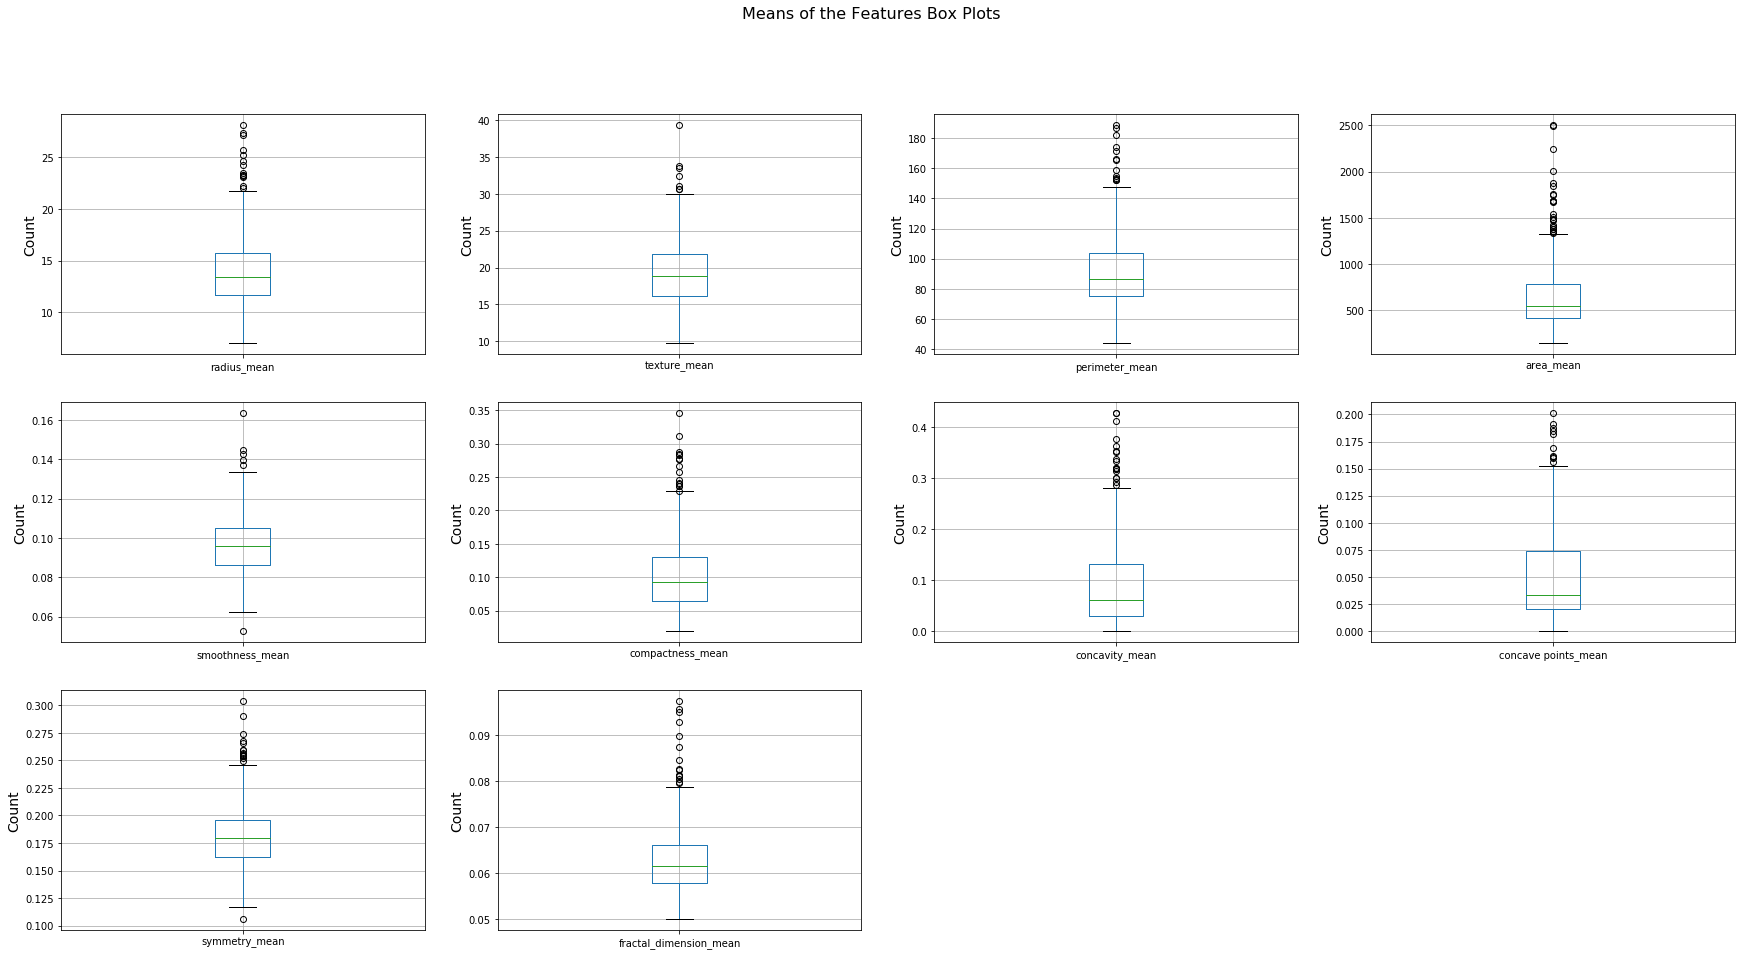

In [8]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[1:11],
           title='Means of the Features Box Plots')

The boxplots show that all the **Mean Features** have outliers in the higher-end, and a median closer to the first quartile, which indicates that all the mean features have positive skewness. The statistic table confirms the skewness of our features since they have their mean greater than their median. For example, the mean of the ***radius_mean*** equals 14.127 μm and its median 13.370 μm. This difference can be explained by the sensitivity of the mean to the outliers.<br>
We can notice that only two features ***smoothness_mean*** and ***symmetry_mean*** have an outlier in the lower band of the graph. This can be related to a biopsy taken from a **benign** lump where the cells show little to no variation in their radius lengths.

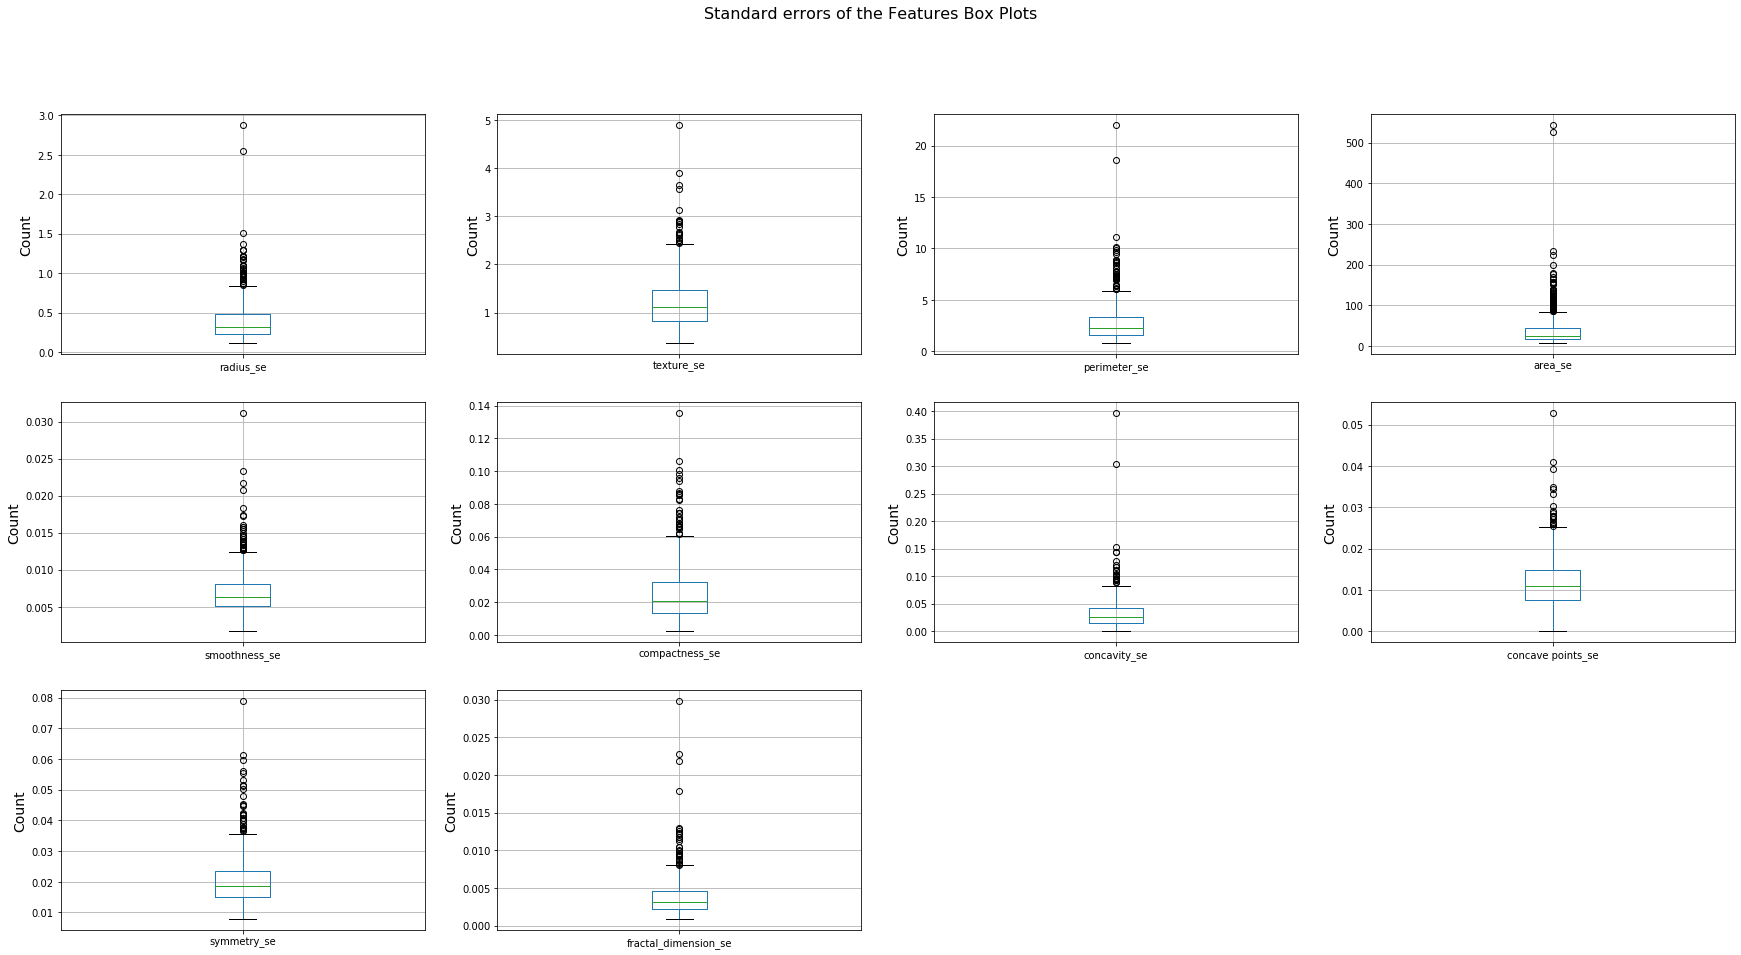

In [9]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[11:21],
           title='Standard errors of the Features Box Plots')

The **Standard Error Features** boxplots show more outliers than the **Mean Features**, it also doesn't display any outlier in the lower-end. And we can notice smaller and more condensed **IQR** regions which indicates a low variability of the middle half of the data. This is confirmed in the statistic table for example the ***radius_se*** has the first quartile of 0.232 μm and the second quartile of 0.479 μm making the IQR equal to 0.247 μm.

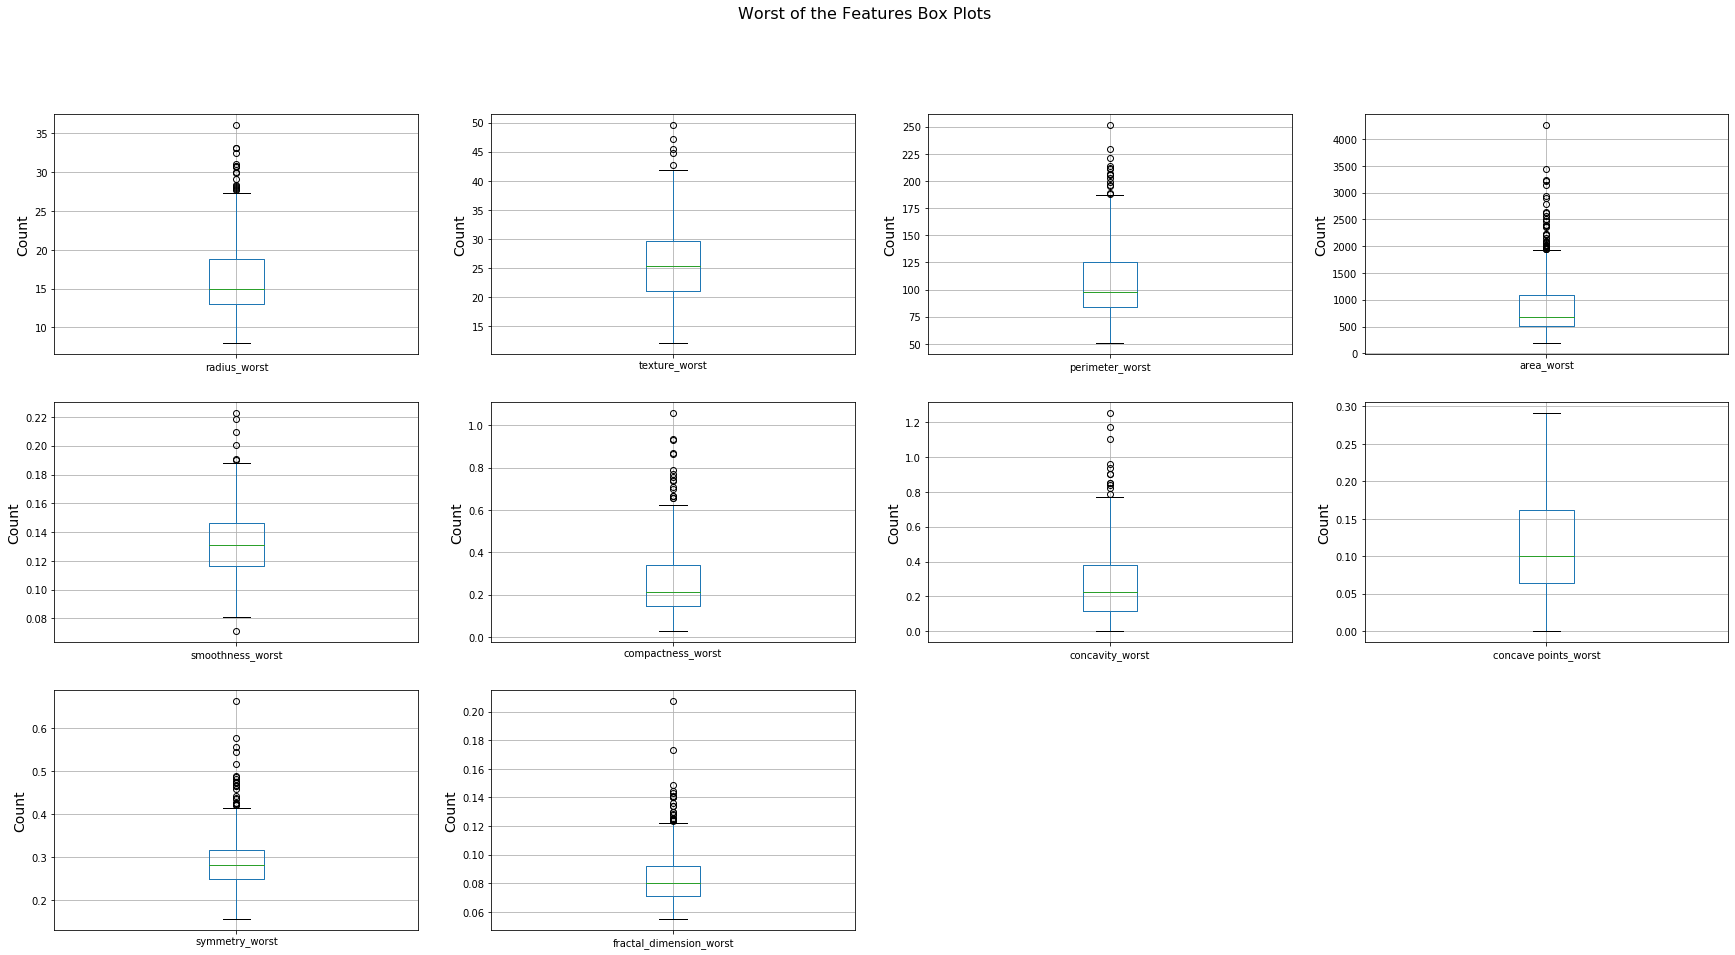

In [10]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[21:],
           title='Worst of the Features Box Plots')

The **Worst Features** boxplots show some similarities with those of the **Mean Features**; in terms of **IQR** width, the presence of outliers in the higher-end, and the positive skewness visible through the median position being closer to the first quartile. We can also see some disparities with the ***concave points_worst*** boxplot not displaying any outlier.

### Bivariate Analysis

In this section, we will explore the effect of each feature on the target variable **"Diagnosis"**. To do so we will use **Boxplots**, **Histograms**, and **Hypothesis testing**.

#### Boxplots

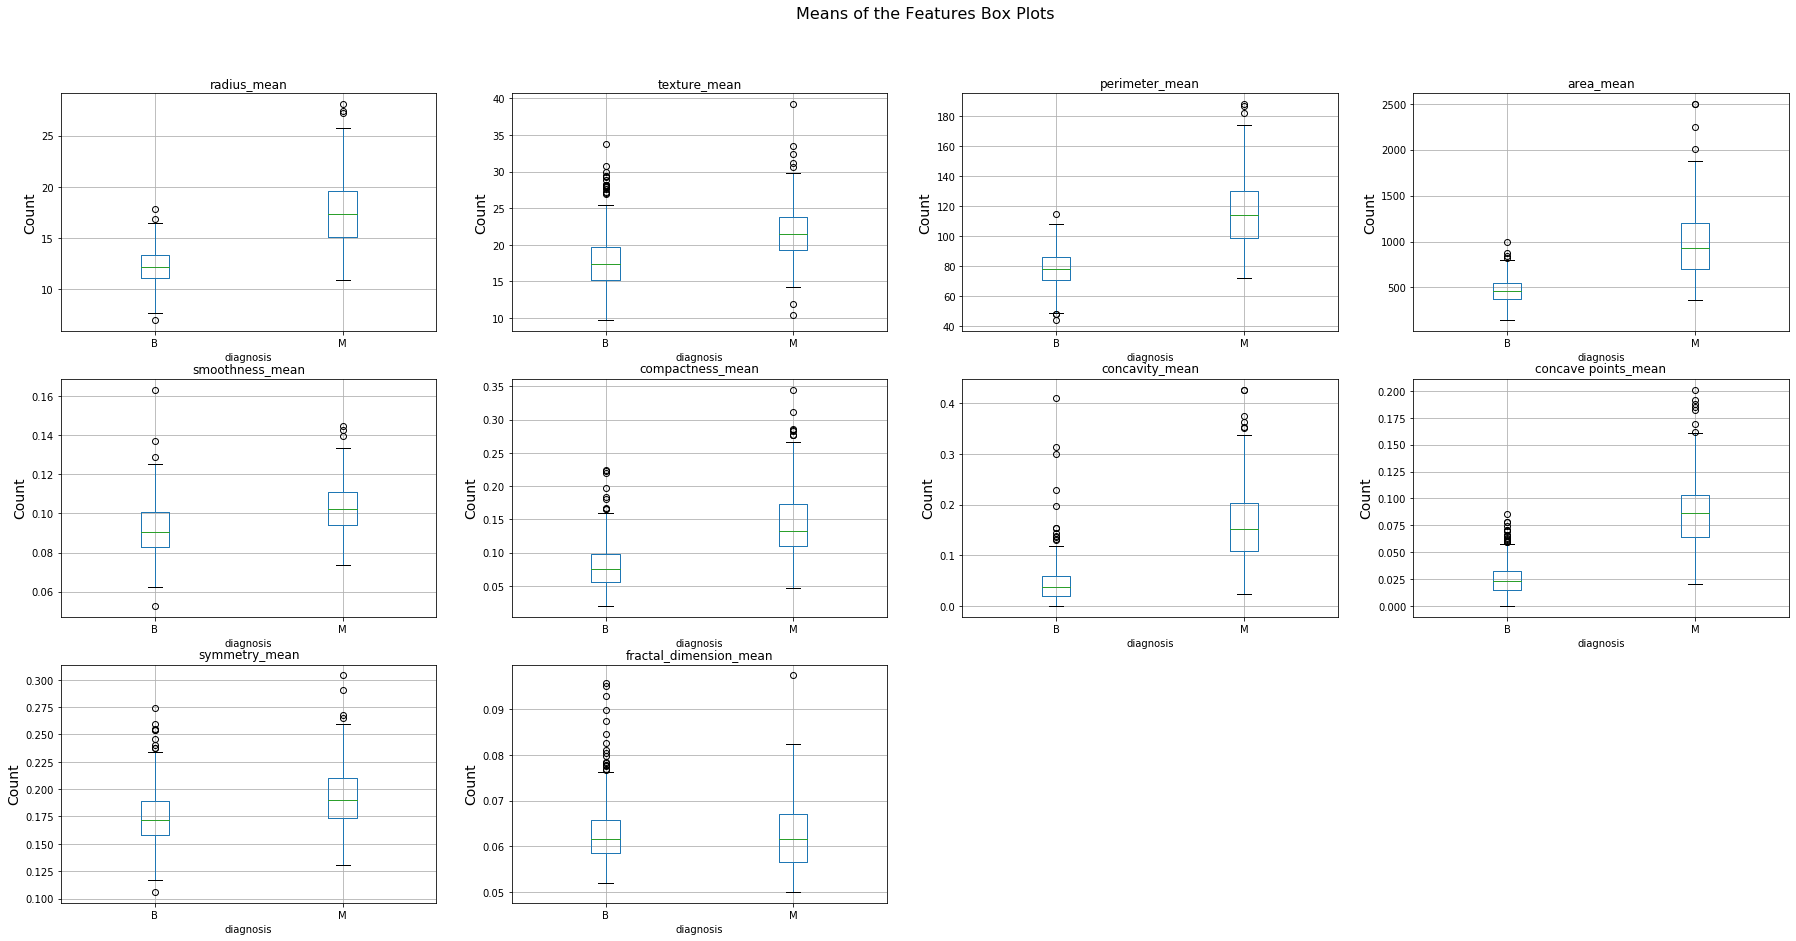

In [11]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[1:11],
           by='diagnosis',
           title='Means of the Features Box Plots')

Across all the graphs of **Mean Features**,  we notice that the **Malignant** boxplots are higher than the **Benign** ones, implying a difference between the distributions of the two samples (the **Malignant**  and the **Benign** samples). We can see that in some features, the two the middle half of the boxplots don't coincide, which indicates that these features have higher effects on the diagnosis: ***radius_mean***, ***perimeter_mean***, ***area_mean***, ***compactness_mean***, ***concavity_mean***, and ***concave points_mean***.

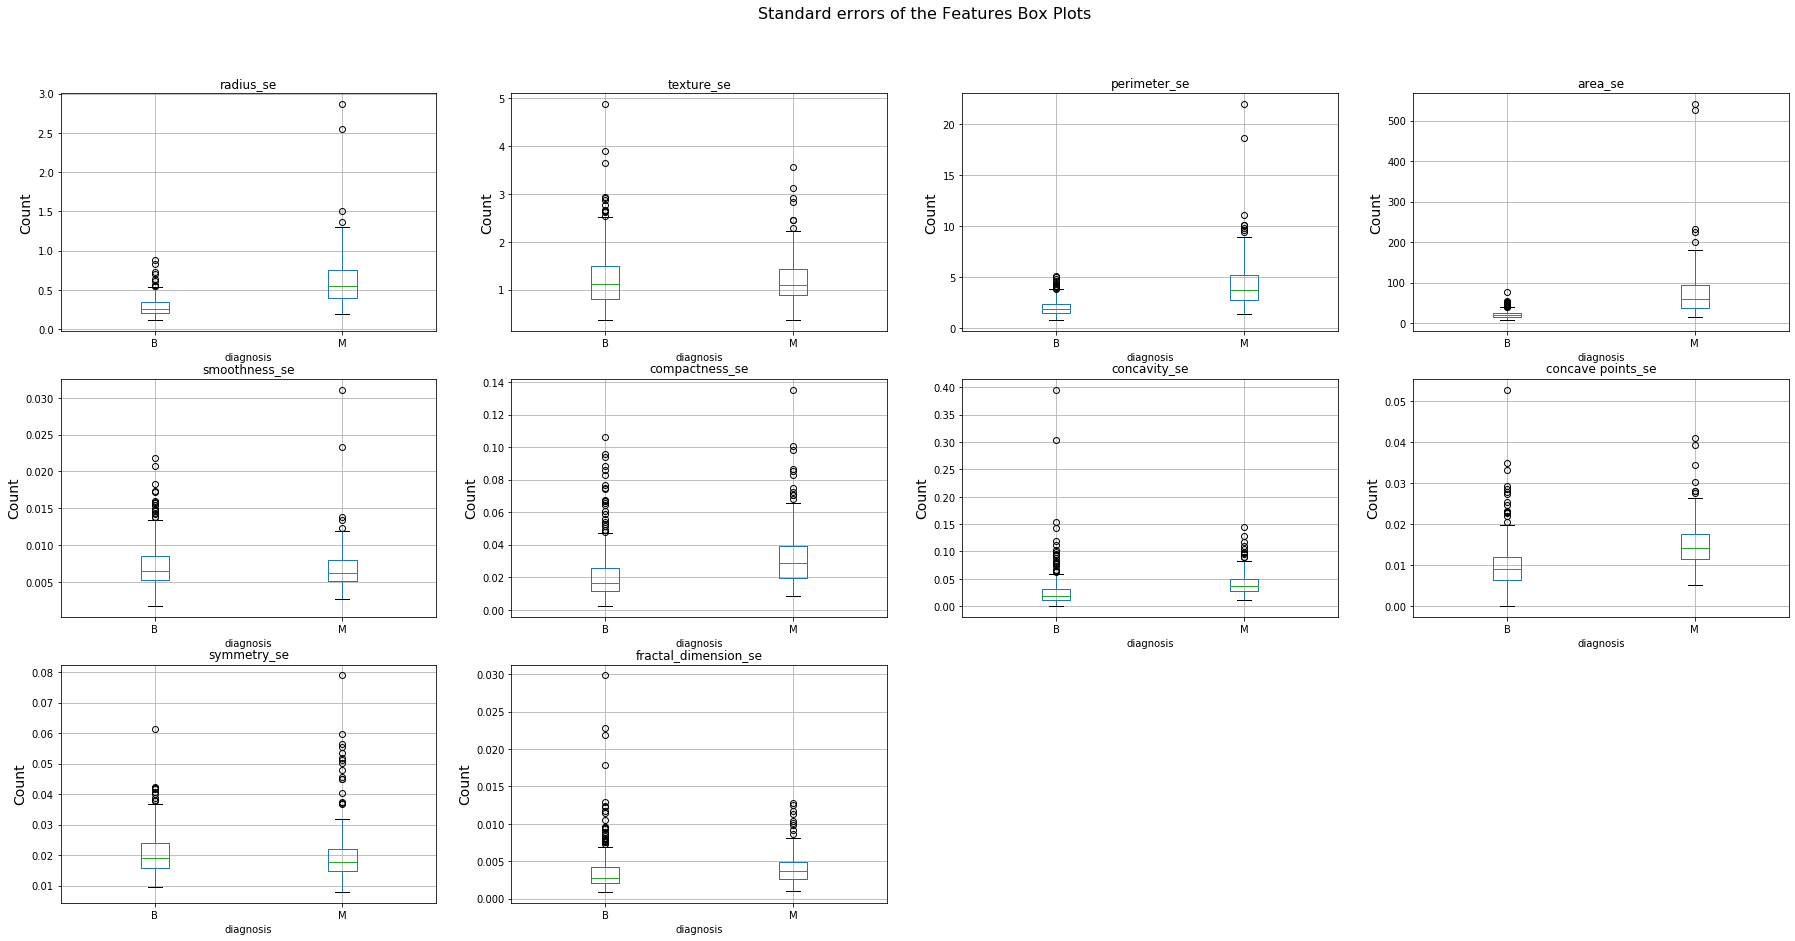

In [12]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[11:21],
           by='diagnosis',
           title='Standard errors of the Features Box Plots')

The difference between the **Malignant** and **Benign** samples are not as apparent in the **Standard Error Features** as the **Mean Features**. We can compare the **Concavity_mean** and the **Concavity_se**, in the first we see clearly that the inner boxes of the two samples don't coincide whereas in the second it is hard to tell.To ensure the veracity of our observations, we can note that some features show distinguishable samples: ***radius_se***, ***perimeter_se*** and ***area_se***. We can say from these observations that **Standard Error Features** have a lower impact on the diagnosis, but this will need confirmation through correlation coefficient and hypothesis testing.

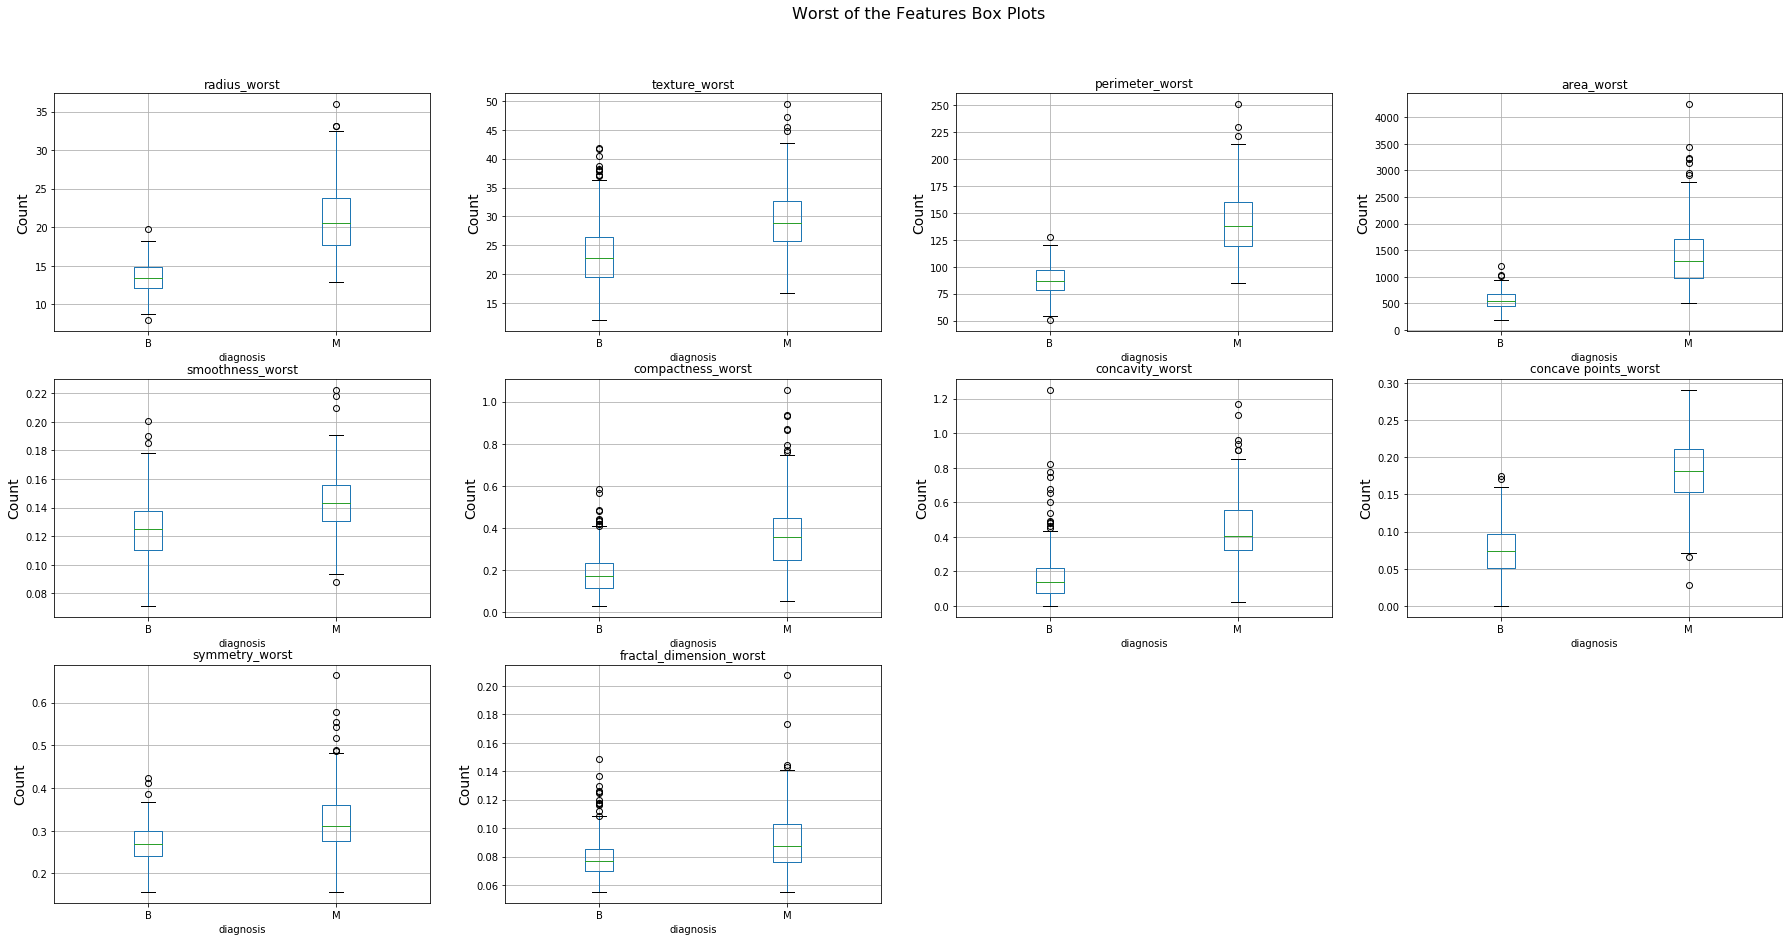

In [13]:
myBoxPlots(rows=3,
           cols=4,
           columns=data.columns[21:],
           by='diagnosis',
           title='Worst of the Features Box Plots')

Compared to the other features, the **Worst Features** show the most differences between the **Malignant** and **Benign** samples. Across all the features, we see that the **Malignant** sample has the highest values, and we expect these features to have to most effect on the diagnosis. This observation can be due to mere chance or be a significant difference. To decide, we will use hypothesis testing.

#### Histograms 

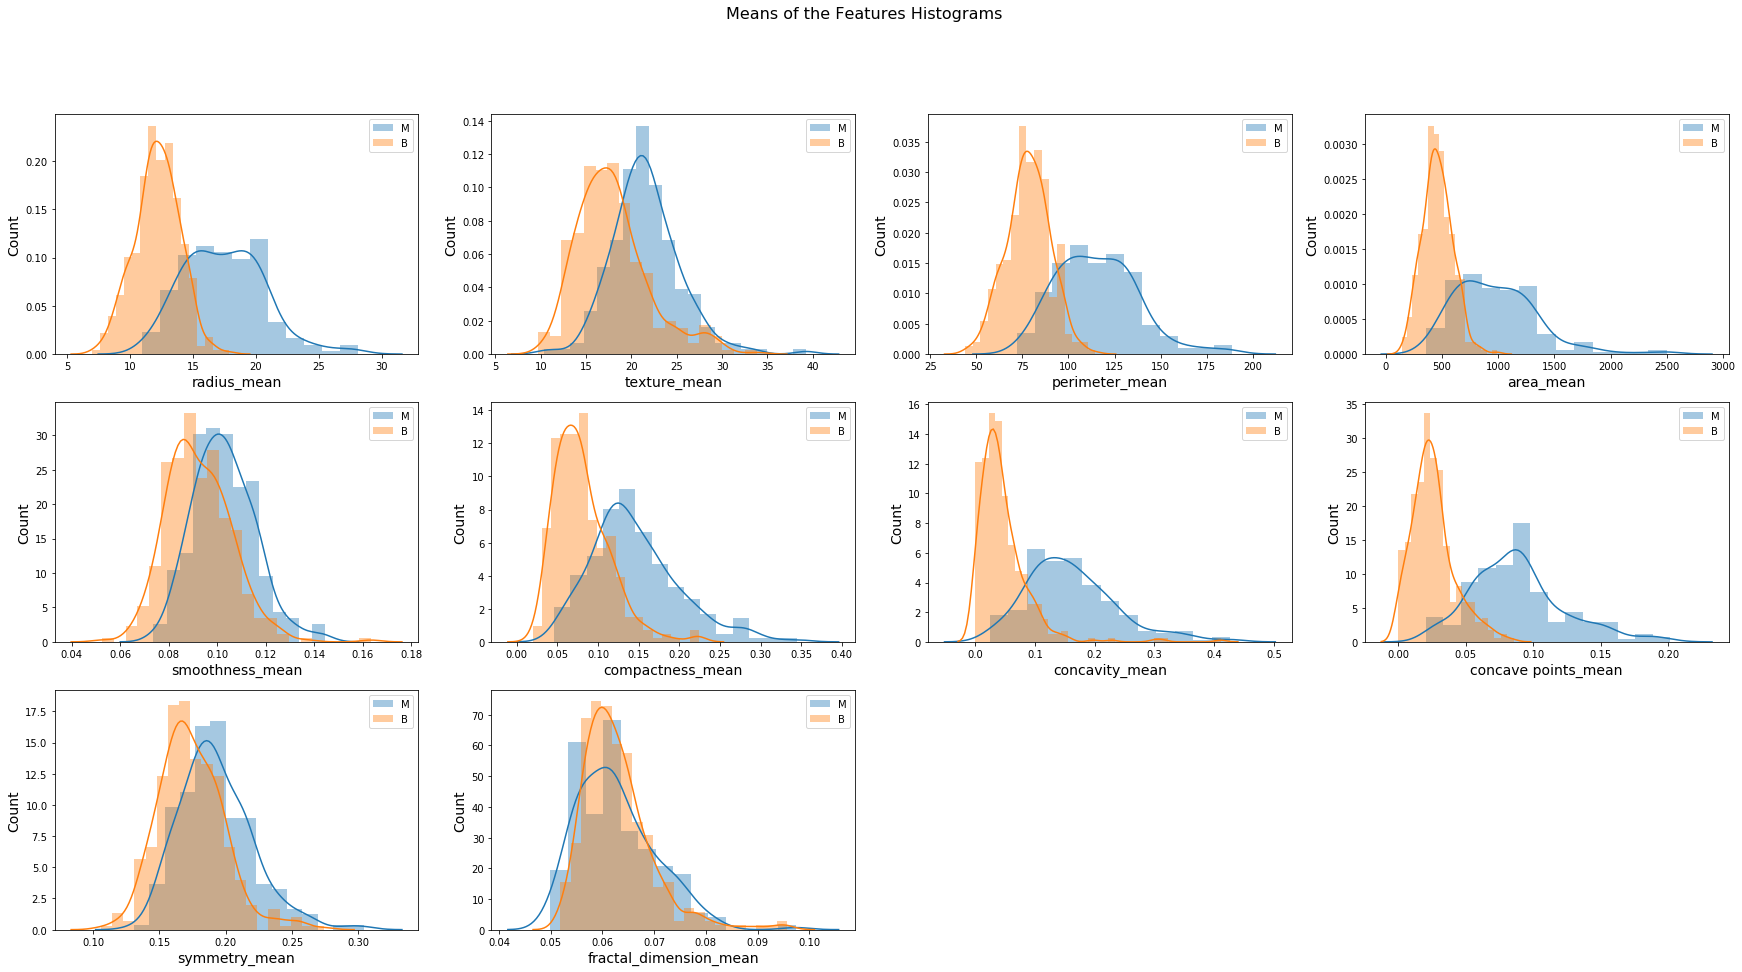

In [14]:
myHistograms(rows=3,
             cols=4,
             columns=data.columns[1:11],
             data=data,
             by='diagnosis',
             title='Means of the Features Histograms')

The histograms of the **Mean Features** confirms the observations drawn from the boxplots: 
- The **Malignant** sample has higher values than the **Benign** sample.
- In all the features except : **smoothness_mean**, **symmetry_mean**, **fractal_dimension_mean**, only a small portion of the two samples overlap.

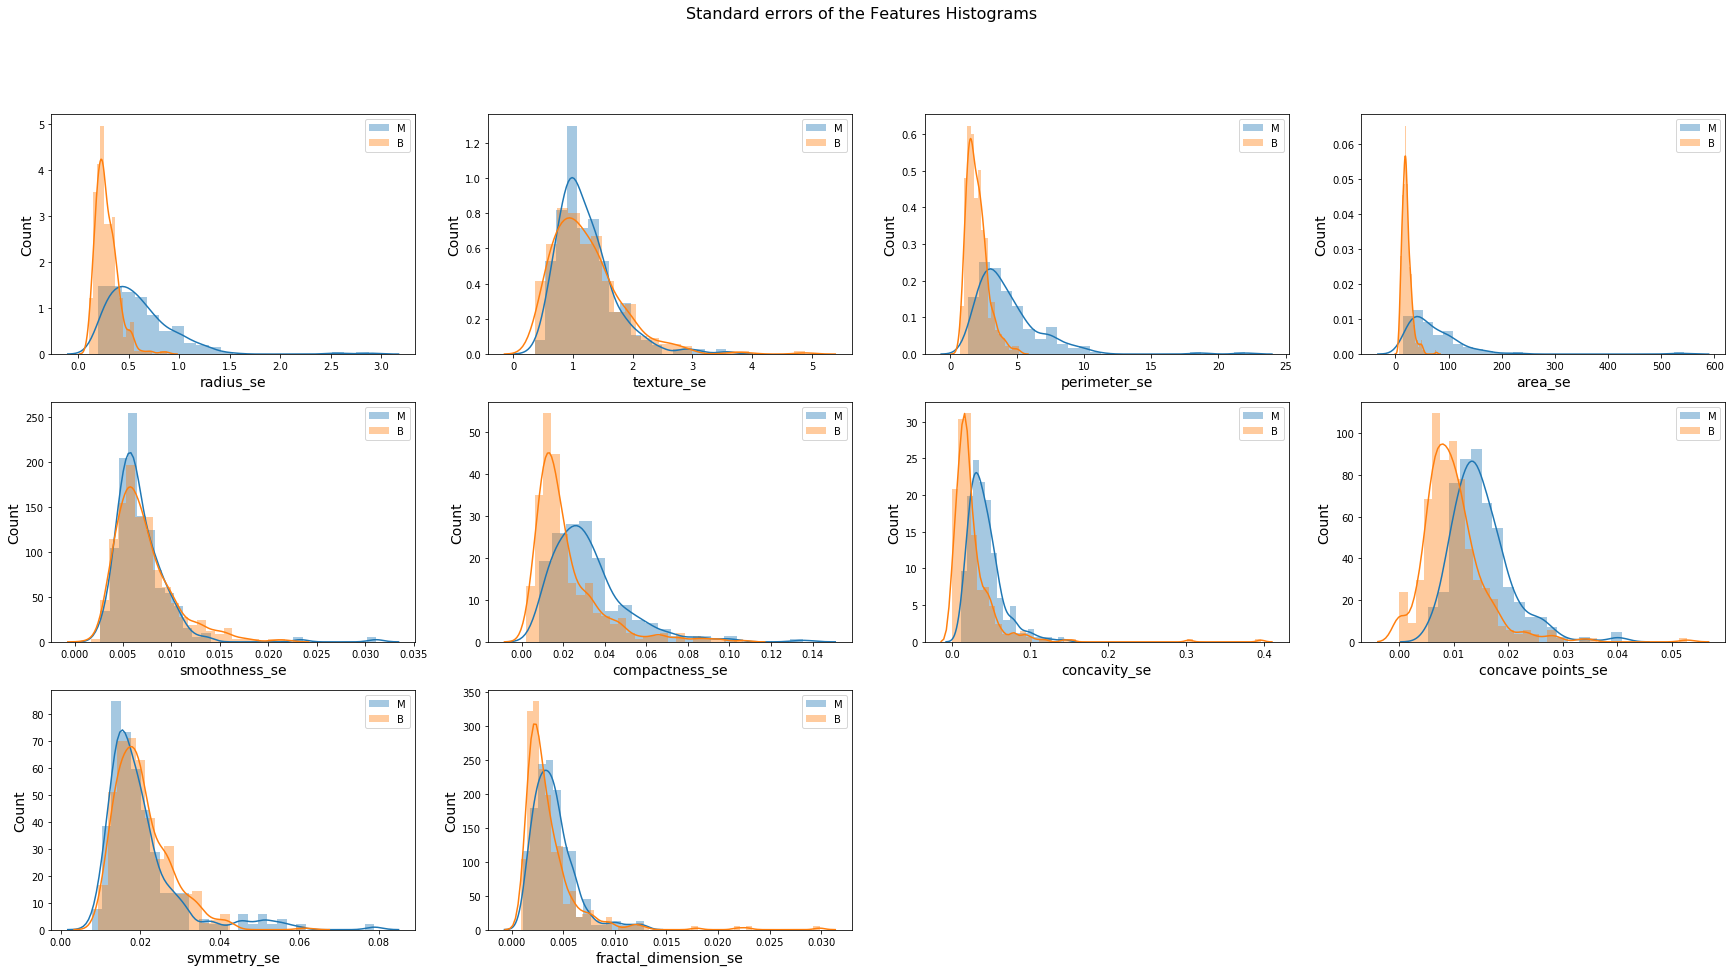

In [15]:
myHistograms(rows=3,
             cols=4,
             columns=data.columns[11:21],
             data=data,
             by='diagnosis',
             title='Standard errors of the Features Histograms')

As observed in the boxplot, the **Standard Error Features** histograms show little to no difference between the **Malignant** and the **Benign** samples. We see in all the features that the graphs of the two subsets overlap. This indicates that these features have little impact on the target variable.

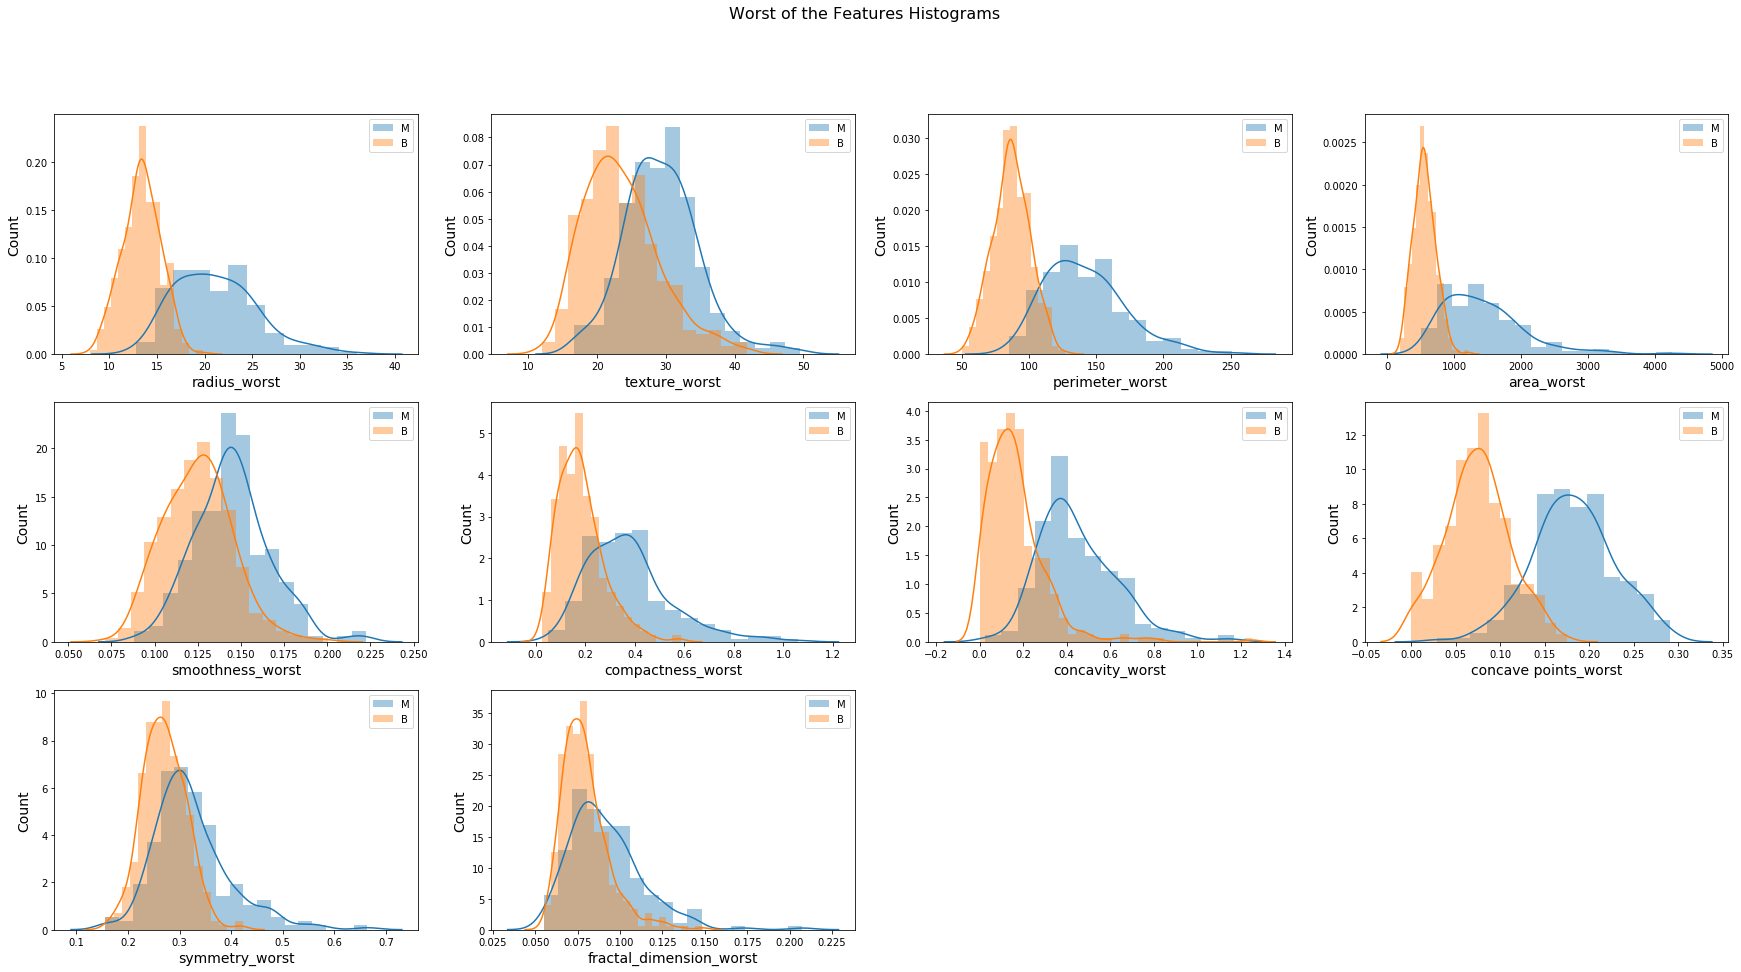

In [16]:
myHistograms(rows=3,
             cols=4,
             columns=data.columns[21:],
             data=data,
             by='diagnosis',
             title='Worst of the Features Histograms')

The overall shape of the **Worst Features** histograms is similar to the **Mean Features** histograms. Hence we can draw the same observation: **Malignant** subsets have higher values and some features show more dissimilarities than others like ***radius_worst*** and ***concave points_worst*** which leads us to think that these features will have more impact on the diagnosis.

#### Hypothesis Testing

To test if there is a significant difference between the features in the **Malignant** and **Benign** datasets, we will use the **two-sample Z-Test**.

In [17]:
# Seperate the observations according to their diagnosis
data_M=data[data['diagnosis']=='M'].iloc[:,1:]
data_B=data[data['diagnosis']=='B'].iloc[:,1:]

In [18]:
print('The size of malignant data set is :',data_M.shape[0])
print('The size of benign data set is :',data_B.shape[0])

The size of malignant data set is : 212
The size of benign data set is : 357


This test assumes that each sample is **Normally distributed** however since our sample sizes are greater than 30 we can use this test.<br>
Our test hypothesis can be formulated as :
- $H_0$ : $\mu_{Malignant} = \mu_{Benign}$.
- $H_1$ : $\mu_{Malignant} \neq \mu_{Benign}$.

And we choose the significance level $\alpha=0.05$

In [19]:
alpha = 0.05 # Set the significance level
column_names = ['Feature','P_Value','P_Value<Alpha'] 
mean_difference = pd.DataFrame(columns = column_names)
for column in data_M.columns:
    stats,p = ztest(data_M[column],data_B[column])
    mean_difference = mean_difference.append(pd.Series([column,p,p<alpha],index=mean_difference.columns),ignore_index=True)

In [20]:
mean_difference[mean_difference['P_Value<Alpha']==True]

Feature        P_Value P_Value<Alpha
0               radius_mean  1.013169e-142          True
1              texture_mean   1.651909e-27          True
2            perimeter_mean  1.193752e-153          True
3                 area_mean  1.212063e-126          True
4           smoothness_mean   5.902670e-20          True
5          compactness_mean   4.314514e-70          True
6            concavity_mean  4.224148e-118          True
7       concave points_mean  2.104724e-189          True
8             symmetry_mean   7.535866e-17          True
10                radius_se   2.030752e-60          True
12             perimeter_se   3.671122e-57          True
13                  area_se   6.288127e-55          True
15           compactness_se   2.940856e-13          True
16             concavity_se   4.206734e-10          True
17        concave points_se   1.889937e-26          True
20             radius_worst  3.293197e-189          True
21            texture_worst   2.123575e-34          True
22          perimeter_worst  2.746145e-197          True
23               area_worst  6.703923e-146          True
24         smoothness_worst   1.818845e-28          True
25        compactness_worst   3.732692e-68          True
26          concavity_worst   5.680856e-97          True
27     concave points_worst  9.902348e-212          True
28           symmetry_worst   1.123752e-27          True
29  fractal_dimension_worst   3.599836e-16          True

In [21]:
mean_difference[mean_difference['P_Value<Alpha']==False]

Feature   P_Value P_Value<Alpha
9   fractal_dimension_mean  0.759825         False
11              texture_se  0.843261         False
14           smoothness_se  0.109740         False
18             symmetry_se  0.876587         False
19    fractal_dimension_se  0.062557         False

The test found that the null hypothesis can be rejected for the majority of the features except : **fractal_dimension_mean**, **texture_se**, **smoothness_se**, **symmetry_se**, and **fractal_dimension_se**. In other words, except for the mentioned features, and with a 95% confidence level, the mean of the features in the **Malignant** sample is not equal to the **Benign** sample. These results confirm some of our observations from the graphs as we found that the **Standard Error Features** show little impact on the diagnosis, we also noticed that the two subsets overlap in the **fractal_dimension_mean**.

In the feature selection step, we can confirm our results by using an algorithm and checking if it has eliminated the features that failed to reject $H_0$.

### Multivariate Analysis

In this section, we will explore the relations between the different features.

#### Pair Grid

##### Means of the Features Pair Grid

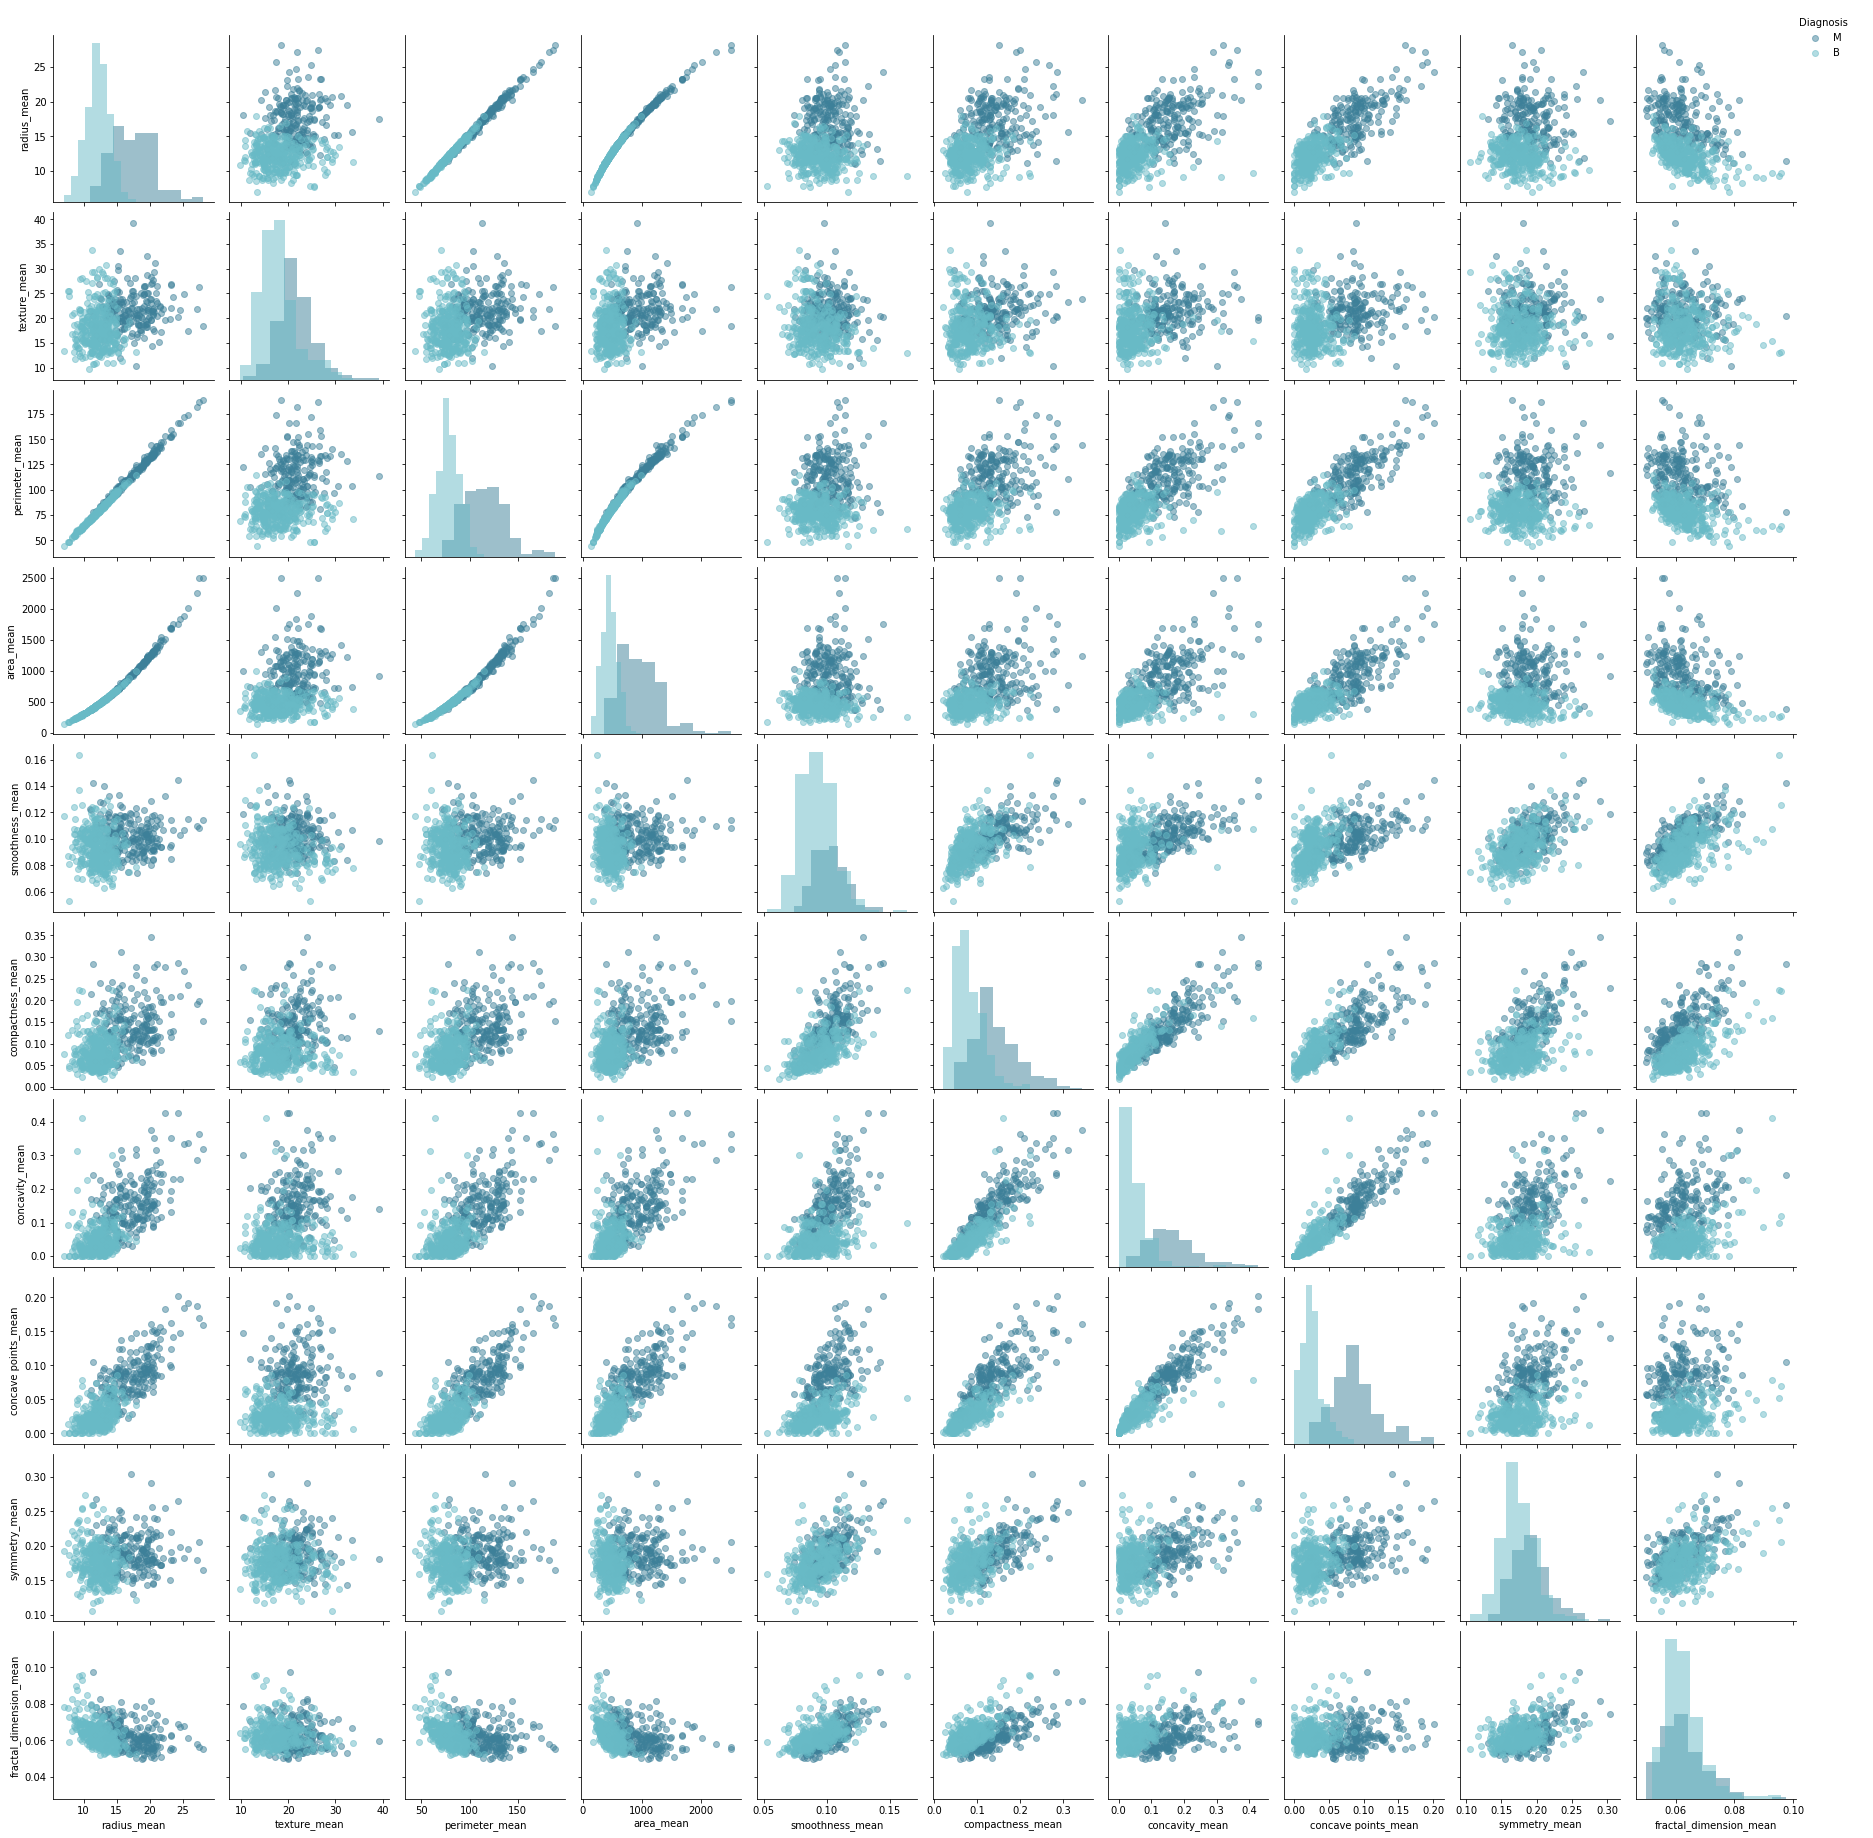

In [22]:
g = sns.PairGrid(data.iloc[:,:11],
                 hue='diagnosis',
                 diag_sharey=False,
                palette="GnBu_d")

g.map_diag(plt.hist,alpha=.5)
g.map_offdiag(plt.scatter, alpha=.5)
g.add_legend(title='Diagnosis', bbox_to_anchor=(1,1))

plt.show()

The scatter plots show a high correlation between the predictors : **radius_mean**, **perimeter_mean**, and **area_mean**. This implies that the same information can be retrieved from one of the three features and we can build our model using one of them.

##### Standard errors of the Features Pair Grid

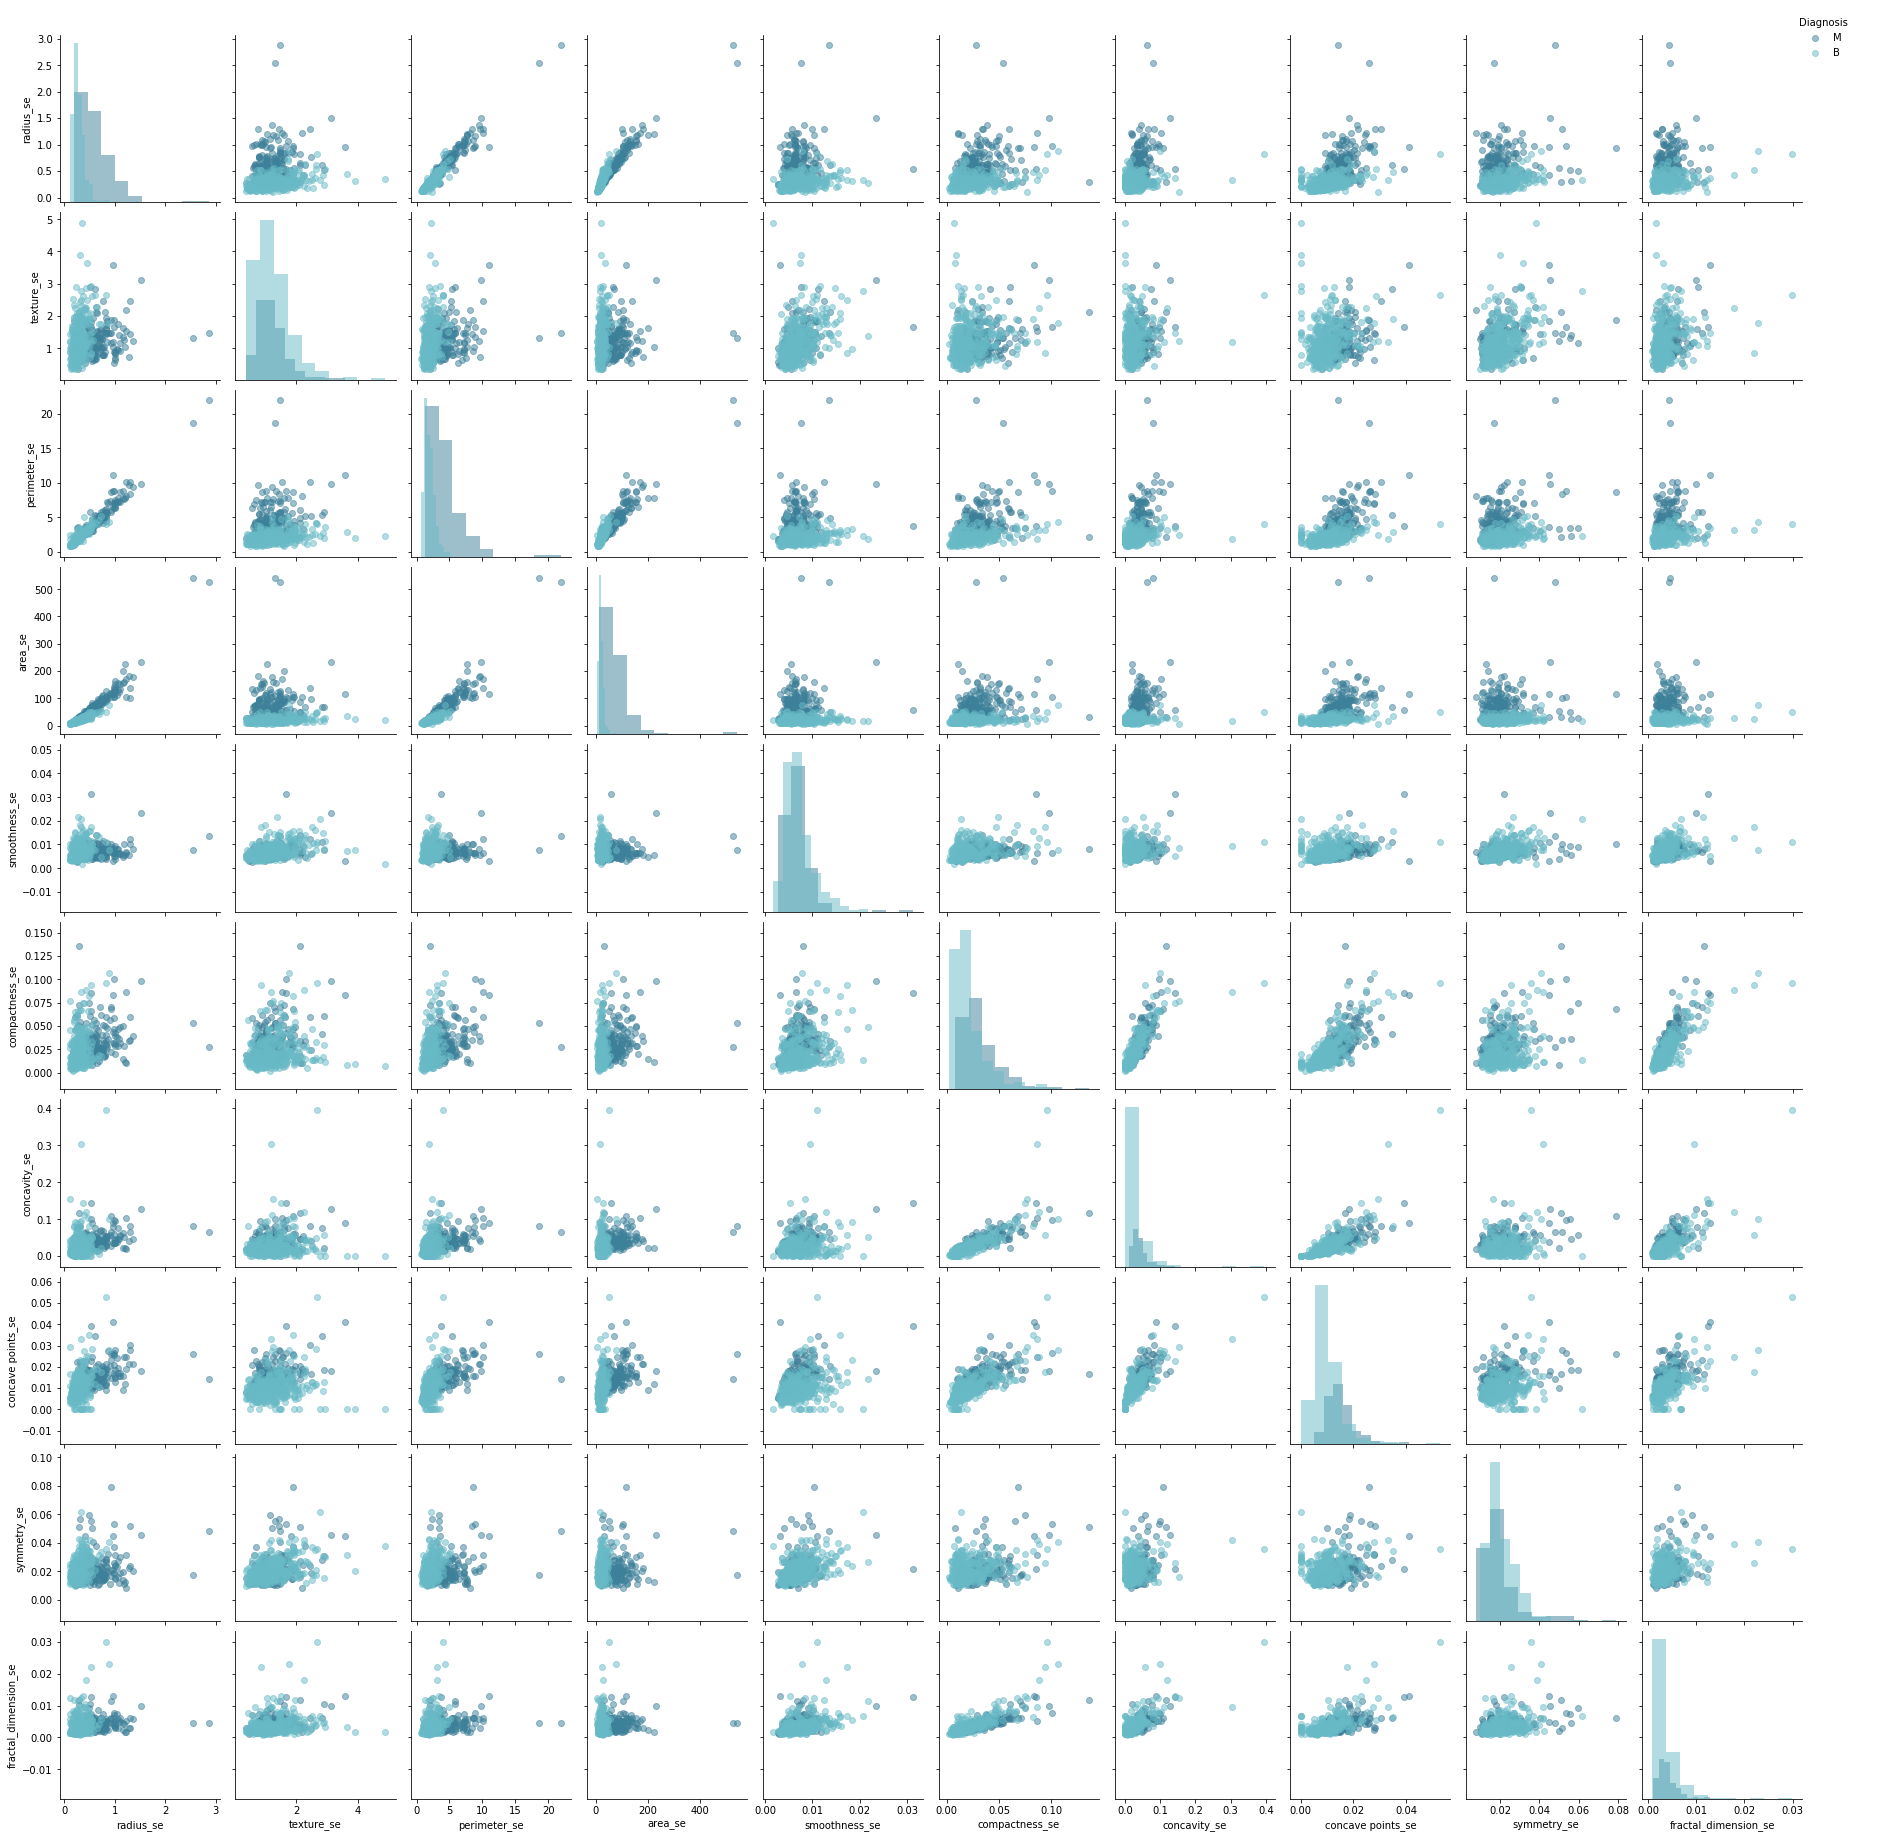

In [23]:
g = sns.PairGrid(data.iloc[:,np.r_[0,11:21]],
                 hue='diagnosis',
                 diag_sharey=False,
                palette="GnBu_d")

g.map_diag(plt.hist,alpha=.5)
g.map_offdiag(plt.scatter, alpha=.5)
g.add_legend(title='Diagnosis', bbox_to_anchor=(1,1))

plt.show()

As for the means scatter plots,the standard errors plots show a correlation between the : **radius**, **perimeter**, and **area**.

##### Worst of the Features Pair Grid

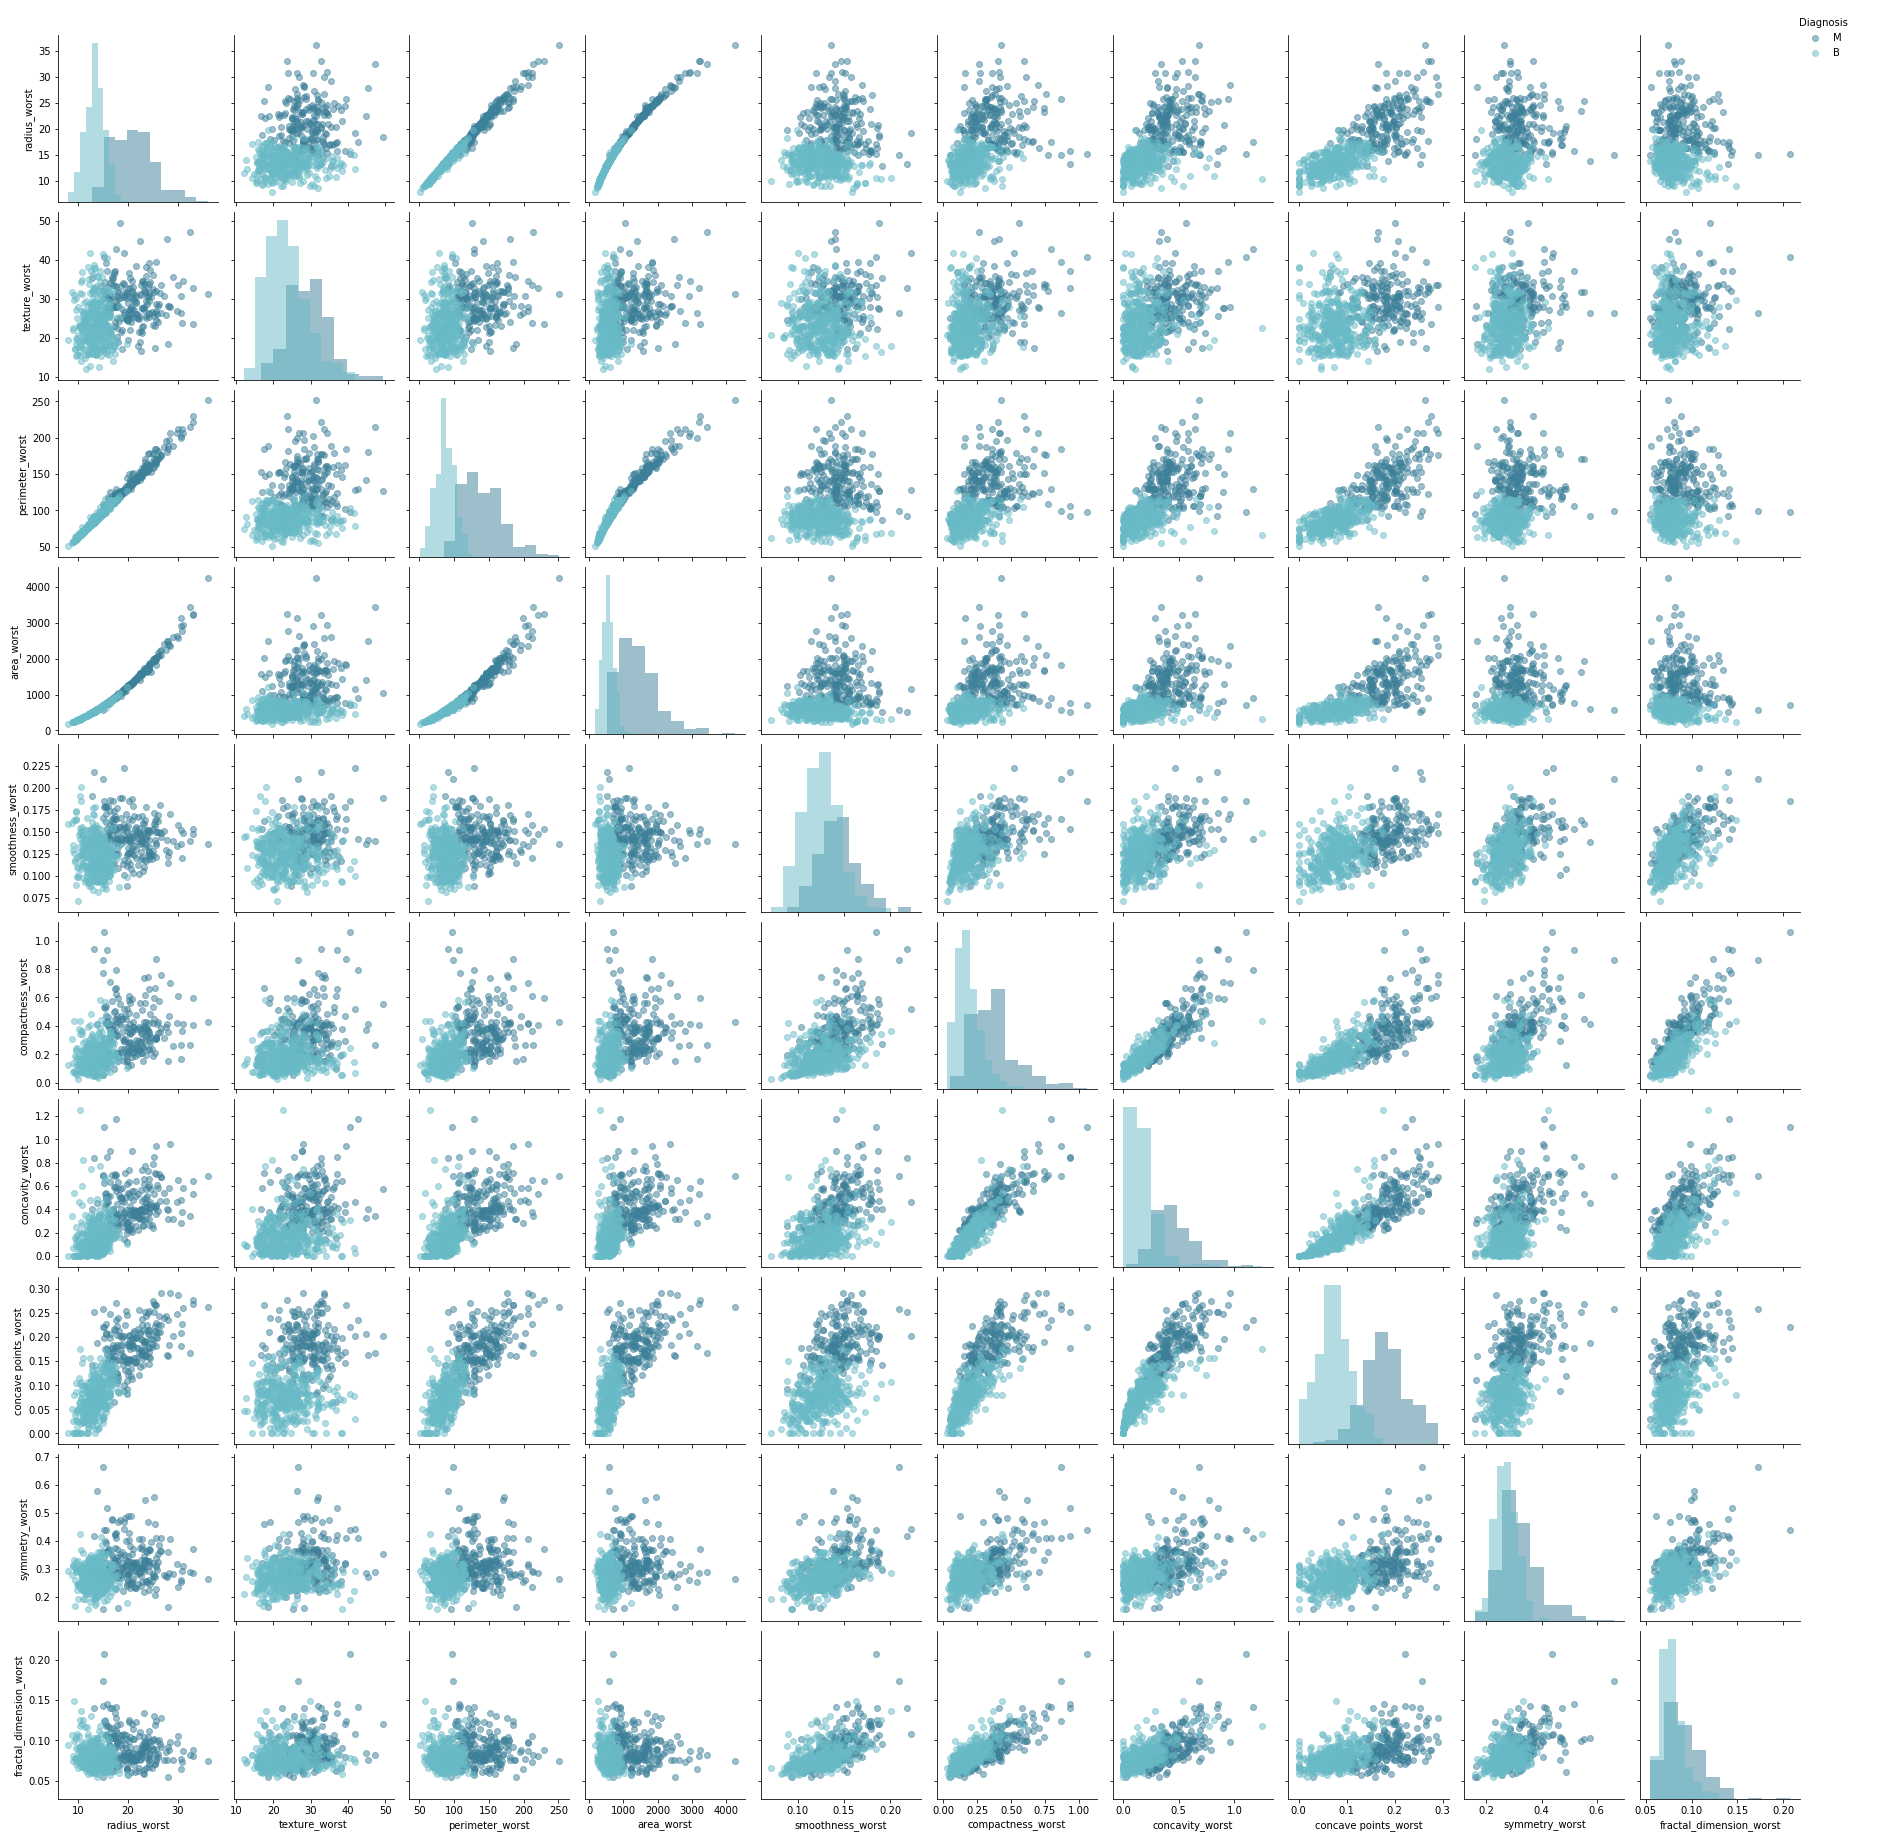

In [24]:
g = sns.PairGrid(data.iloc[:,np.r_[0,21:31]],
                 hue='diagnosis',
                 diag_sharey=False,
                palette="GnBu_d")

g.map_diag(plt.hist,alpha=.5)
g.map_offdiag(plt.scatter, alpha=.5)
g.add_legend(title='Diagnosis', bbox_to_anchor=(1,1))

plt.show()

We can draw the same conclusion as previous plots, we see a correlation between the: **radius**, **perimeter**, and **area**.

#### Correlation Matrix

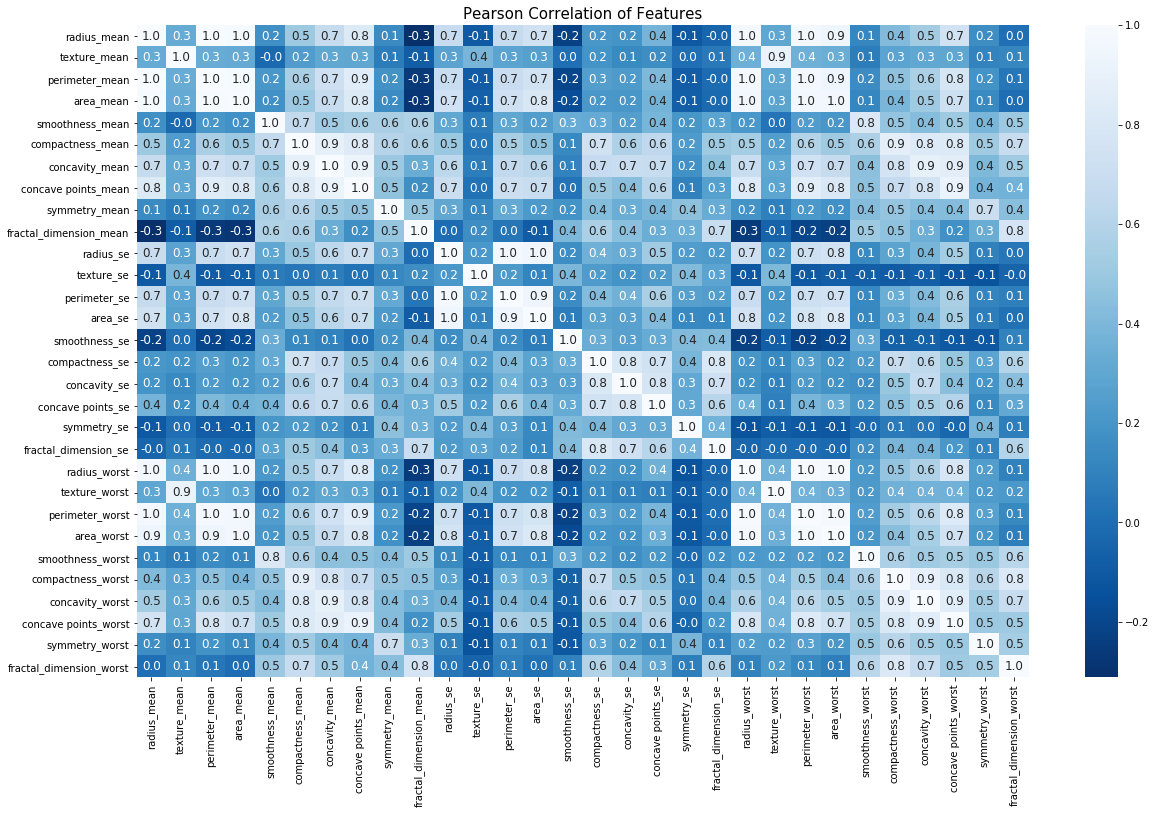

In [25]:
plt.figure(figsize=(20,12))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(data.iloc[:,1:].corr(),
            annot=True,
            annot_kws={'fontsize':12 },
            fmt='.1f',
            cmap='Blues_r')
plt.show()

The correlation matrix confirmed the correlation between : **radius**, **perimeter**, and **area**.
- **radius_mean**, **perimeter_mean**, and **area_mean** with a pearson correlation coefficient equal to 1.
- **radius_se**, **perimeter_se**, and **area_se** with a pearson correlation coefficient equal to 1.
- **radius_worst**, **perimeter_worst**, and **area_worst** with a pearson correlation coefficient equal to 1.<br>

In addition to the correlation seen in the plots, the matrix shows other coreelation between the predictors , we choose as a coefficient threshold **0.9**:
- **radius_mean**, **perimeter_mean**, **area_mean**, **radius_worst**, **perimeter_worst**, and **area_worst**.
- **texture_mean** and **texture_worst**.
- **perimeter_mean** and **concave_points_mean**.
- **compactness_mean** and **compactness_worst**.
- **concavity_mean**, **compactness_mean**, **concave_points_mean**, **concavity_worst** and **concave_points_worst**.<br>

In the following, we will compare the classification algorithm performance with and without the correlated features. These features are selected using this snippet from [[3]](#ref3).

In [26]:
correlated_features = set()
correlation_matrix = data.iloc[:,1:].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
correlated_features

{'area_mean',
 'area_se',
 'area_worst',
 'compactness_worst',
 'concave points_mean',
 'concave points_worst',
 'concavity_mean',
 'concavity_worst',
 'perimeter_mean',
 'perimeter_se',
 'perimeter_worst',
 'radius_worst',
 'texture_worst'}

## Data Preprocessing

In this section, we will prepare our dataset for the classification step. To evaluate the impact of eliminating correlated features we will also prepare a dataset where we have deleted the correlated variables.<br>
First, we will separate the columns of our data set into a target variable **y** and predictors **X**.

In [27]:
X = data.iloc[:,1:]                               #Omit the first column (diagnosis) the result will a pandas.dataframe
y = data.iloc[:,0]                                #Retrieve the first column (diagnosis) the result will a pandas.series
#Show the first 5 lines of X
X.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  \
0                 0.07871     1.0950      0.9053         8.589   153.40   
1                 0.05667     0.5435      0.7339         3.398    74.08   
2                 0.05999     0.7456      0.7869         4.585    94.03   
3                 0.09744     0.4956      1.1560         3.445    27.23   
4                 0.05883     0.7572      0.7813         5.438    94.44   

   smoothness_se  compactness_se  concavity_se  concave points_se  \
0       0.006399         0.04904       0.05373            0.01587   
1       0.005225         0.01308       0.01860            0.01340   
2       0.006150         0.04006       0.03832            0.02058   
3       0.009110         0.07458       0.05661            0.01867   
4       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

In [28]:
X_NotCorrelated = X.drop(columns=correlated_features)     #Omit the correlated features
#Show the first 5 lines of X_NotCorrelated
X_NotCorrelated.head()

radius_mean  texture_mean  smoothness_mean  compactness_mean  \
0        17.99         10.38          0.11840           0.27760   
1        20.57         17.77          0.08474           0.07864   
2        19.69         21.25          0.10960           0.15990   
3        11.42         20.38          0.14250           0.28390   
4        20.29         14.34          0.10030           0.13280   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  \
0         0.2419                 0.07871     1.0950      0.9053   
1         0.1812                 0.05667     0.5435      0.7339   
2         0.2069                 0.05999     0.7456      0.7869   
3         0.2597                 0.09744     0.4956      1.1560   
4         0.1809                 0.05883     0.7572      0.7813   

   smoothness_se  compactness_se  concavity_se  concave points_se  \
0       0.006399         0.04904       0.05373            0.01587   
1       0.005225         0.01308       0.01860            0.01340   
2       0.006150         0.04006       0.03832            0.02058   
3       0.009110         0.07458       0.05661            0.01867   
4       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  smoothness_worst  symmetry_worst  \
0      0.03003              0.006193            0.1622          0.4601   
1      0.01389              0.003532            0.1238          0.2750   
2      0.02250              0.004571            0.1444          0.3613   
3      0.05963              0.009208            0.2098          0.6638   
4      0.01756              0.005115            0.1374          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

Encode the categorical values of our target variable **y**, replacing :
- **'M'**(malignant) with **1**.
- **'B'**(Benign) with **0**.

In [29]:
y = y.replace({'M':1,'B':0})

Since our dataset doesn't contain any missing data,we will not have to deal with missing data in our preprocessing stage.<br>
Then we will separate our datasets into a training and test sets.

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=0)
#Show the first 5 lines of X_train
X_train.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
338        10.05         17.53           64.41      310.8          0.10070   
427        10.80         21.98           68.79      359.9          0.08801   
406        16.14         14.86          104.30      800.0          0.09495   
96         12.18         17.84           77.79      451.1          0.10450   
490        12.25         22.44           78.18      466.5          0.08192   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
338           0.07326         0.02511              0.01775         0.1890   
427           0.05743         0.03614              0.01404         0.2016   
406           0.08501         0.05500              0.04528         0.1735   
96            0.07057         0.02490              0.02941         0.1900   
490           0.05200         0.01714              0.01261         0.1544   

     fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  \
338                 0.06331     0.2619      2.0150         1.778    16.85   
427                 0.05977     0.3077      1.6210         2.240    20.20   
406                 0.05875     0.2387      0.6372         1.729    21.83   
96                  0.06635     0.3661      1.5110         2.410    24.44   
490                 0.05976     0.2239      1.1390         1.577    18.04   

     smoothness_se  compactness_se  concavity_se  concave points_se  \
338       0.007803         0.01449       0.01690           0.008043   
427       0.006543         0.02148       0.02991           0.010450   
406       0.003958         0.01246       0.01831           0.008747   
96        0.005433         0.01179       0.01131           0.015190   
490       0.005096         0.01205       0.00941           0.004551   

     symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
338      0.02100              0.002778         11.16          26.84   
427      0.01844              0.002690         12.76          32.04   
406      0.01500              0.001621         17.71          19.58   
96       0.02220              0.003408         12.83          20.92   
490      0.01608              0.002399         14.17          31.99   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
338            71.98       384.0            0.1402            0.14020   
427            83.69       489.5            0.1303            0.16960   
406           115.90       947.9            0.1206            0.17220   
96             82.14       495.2            0.1140            0.09358   
490            92.74       622.9            0.1256            0.18040   

     concavity_worst  concave points_worst  symmetry_worst  \
338           0.1055               0.06499          0.2894   
427           0.1927               0.07485          0.2965   
406           0.2310               0.11290          0.2778   
96            0.0498               0.05882          0.2227   
490           0.1230               0.06335          0.3100   

     fractal_dimension_worst  
338                  0.07664  
427                  0.07662  
406                  0.07012  
96                   0.07376  
490                  0.08203

In [31]:
XNC_train,XNC_test,yNC_train,yNC_test = train_test_split(X_NotCorrelated,y,test_size=0.2, random_state=0)
#Show the first 5 lines of XNC_train
XNC_train.head()

radius_mean  texture_mean  smoothness_mean  compactness_mean  \
338        10.05         17.53          0.10070           0.07326   
427        10.80         21.98          0.08801           0.05743   
406        16.14         14.86          0.09495           0.08501   
96         12.18         17.84          0.10450           0.07057   
490        12.25         22.44          0.08192           0.05200   

     symmetry_mean  fractal_dimension_mean  radius_se  texture_se  \
338         0.1890                 0.06331     0.2619      2.0150   
427         0.2016                 0.05977     0.3077      1.6210   
406         0.1735                 0.05875     0.2387      0.6372   
96          0.1900                 0.06635     0.3661      1.5110   
490         0.1544                 0.05976     0.2239      1.1390   

     smoothness_se  compactness_se  concavity_se  concave points_se  \
338       0.007803         0.01449       0.01690           0.008043   
427       0.006543         0.02148       0.02991           0.010450   
406       0.003958         0.01246       0.01831           0.008747   
96        0.005433         0.01179       0.01131           0.015190   
490       0.005096         0.01205       0.00941           0.004551   

     symmetry_se  fractal_dimension_se  smoothness_worst  symmetry_worst  \
338      0.02100              0.002778            0.1402          0.2894   
427      0.01844              0.002690            0.1303          0.2965   
406      0.01500              0.001621            0.1206          0.2778   
96       0.02220              0.003408            0.1140          0.2227   
490      0.01608              0.002399            0.1256          0.3100   

     fractal_dimension_worst  
338                  0.07664  
427                  0.07662  
406                  0.07012  
96                   0.07376  
490                  0.08203

 Then we will do some feature scaling, we will use standardization which doesn't affect outliers.

In [32]:
# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

scale = StandardScaler().fit(X_train_stand)  

# transform the training data column
X_train_stand = scale.transform(X_train_stand)

# transform the testing data column
X_test_stand = scale.transform(X_test_stand)

In [33]:
# copy of datasets
XNC_train_stand = XNC_train.copy()
XNC_test_stand = XNC_test.copy()

scaleNC = StandardScaler().fit(XNC_train_stand)  

# transform the training data column
XNC_train_stand = scaleNC.transform(XNC_train_stand)

# transform the testing data column
XNC_test_stand = scaleNC.transform(XNC_test_stand)

The final step in our data preprocessing is feature selection. We will use the **Anova F Mesure** to sort the features, then we will select the variables with the highest scores in the classification step.

In [34]:
#Compute the F Mesure and Pvalues
Fs,Pvals = f_classif(X_train_stand,y_train)
# get the sorted indices of the features according to their scores
sort_indice = np.flip(np.argsort(Fs))
# get the columns names 
columns_Sorted = X.columns[sort_indice]

In [35]:
#Compute the F Mesure and Pvalues
FsNC,PvalsNC = f_classif(XNC_train_stand,y_train)
# get the sorted indices of the features according to their scores
sort_indiceNC = np.flip(np.argsort(FsNC))
# get the columns names 
columns_SortedNC = X_NotCorrelated.columns[sort_indiceNC]

In [36]:
columns_Sorted

Index(['concave points_worst', 'perimeter_worst', 'concave points_mean',
       'radius_worst', 'perimeter_mean', 'radius_mean', 'area_worst',
       'area_mean', 'concavity_mean', 'concavity_worst', 'compactness_mean',
       'compactness_worst', 'radius_se', 'perimeter_se', 'area_se',
       'texture_worst', 'smoothness_worst', 'symmetry_worst', 'texture_mean',
       'concave points_se', 'smoothness_mean', 'symmetry_mean',
       'fractal_dimension_worst', 'compactness_se', 'concavity_se',
       'smoothness_se', 'fractal_dimension_se', 'fractal_dimension_mean',
       'texture_se', 'symmetry_se'],
      dtype='object')

In [37]:
columns_SortedNC

Index(['radius_mean', 'compactness_mean', 'radius_se', 'smoothness_worst',
       'symmetry_worst', 'texture_mean', 'concave points_se',
       'smoothness_mean', 'symmetry_mean', 'fractal_dimension_worst',
       'compactness_se', 'concavity_se', 'smoothness_se',
       'fractal_dimension_se', 'fractal_dimension_mean', 'texture_se',
       'symmetry_se'],
      dtype='object')

The results of the **Anova** confirms what we found earlier in the **Hypothesis Test**, since the five features with the lowest score are : ***fractal_dimension_mean***, ***texture_se***, ***smoothness_se***, ***symmetry_se***, and ***fractal_dimension_se*** and these same variables are the ones that failed to reject the null hypothesis $H_0$ : $\mu_{Malignant} = \mu_{Benign}$.

## Classification

In this step, we will test six classification algorithms: **K-Nearest Neighbors**, **Logistic Regression**, **Naive Bayes**, **Support Vectors Machine**, **Decision Tree**, and **Random Forest**. And for each algorithm, we will follow the same protocol:
- Tune the model using all the features.
- Build models with different number features with the tuned parameters.
- Use 5-K cross validation with the scoring methods : **Accuracy**, **Precision**, **Recall**, **F1_Score** and **ROC_AUC**.
- Store the result in a dataframe that we will call ***metrics***.
- Evaluate the results to find the optimal features number and algorithm.


### Evaluating the Algorithms on the Training Set:

We will state by using ***GridSearchCV*** to tune the parametes.
- K-Nearest Neighbors : The number of neighbors.
- Logistic Regression : The tolerance for stopping criteria,and inverse of regularization strength.
- Support Vectors Machine : The tolerance for stopping criteria,and inverse of regularization strength.
- Decision Tree : The criterion parameter.
- Random Forest : The criterion parameter, and the number of estimators.

In [38]:
parameters = [{'n_neighbors':[3,4,5,6,7,8]},
              {'tol':[1e-7,1e-6,1e-5,1e-4,1e-3],'C':[1e-3,1e-2,1e-1,1,10,100]},
              {'tol':[1e-7,1e-6,1e-5,1e-4,1e-3],'C':[1e-3,1e-2,1e-1,1,10,100]},
              {'criterion':['gini','entropy']},
              {'n_estimators':[100,500,1000,1500,2000],'criterion':['gini','entropy']}]

knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000)
svc = SVC(max_iter=10000)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

algorithms = [knn,lr,svc,tree,forest]

for algo,param in zip(algorithms,parameters):
    clf = GridSearchCV(algo, param)
    clf.fit(X_train_stand, y_train)
    print(clf.best_params_)

{'n_neighbors': 4}
{'C': 1, 'tol': 1e-07}
{'C': 1, 'tol': 1e-07}
{'criterion': 'entropy'}
{'criterion': 'entropy', 'n_estimators': 500}


We will used the tuned parameters to build our model then use **5-Cross Validation** to evaluate each classification for different number of features.

In [39]:
#create a new models
knn = KNeighborsClassifier(n_neighbors=4)
LR = LogisticRegression(tol = 1e-7, C=1, max_iter=1000) 
NB = GaussianNB()
svc = SVC(tol = 1e-7, C=1, max_iter=10000)
tree = DecisionTreeClassifier(criterion='entropy')
RF = RandomForestClassifier(criterion='gini',n_estimators=1500)

algorithms = [knn,LR,NB,svc,tree,RF]
algorithmsNames = ['K-Nearest Neighbors','Logistic Regression','Naive Bayes','Support Vector Machine','Decision Tree','Random Forest']


column_names = ['Algorithm','Number_Columns','Accuracy','Precision','Recall','F1_Score','ROC_AUC']
metrics = pd.DataFrame(columns = column_names)

for clf,clfName in zip(algorithms,algorithmsNames):
        
        for stp in range(30,0,-1):
            indices = sort_indice[:stp]
            X_selected = X_train_stand[:,indices]
            cv_scores = cross_val_score(clf, X_selected, y_train, cv=5)
            #train model using precision
            cv_scores_precision = cross_val_score(clf, X_selected, y_train, cv=5, scoring='precision')
            #train model using Recall
            cv_scores_recall = cross_val_score(clf, X_selected, y_train, cv=5, scoring='recall')
            #train model using f1 score
            cv_scores_f1 = cross_val_score(clf, X_selected, y_train, cv=5, scoring='f1')
            #train model using roc_auc
            cv_scores_roc_auc = cross_val_score(clf, X_selected, y_train, cv=5, scoring='roc_auc')

            metrics=metrics.append(pd.Series([clfName, stp ,np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                                     index=metrics.columns),
                           ignore_index=True)

In [41]:
metrics.head()

Algorithm Number_Columns  Accuracy  Precision    Recall  \
0  K-Nearest Neighbors             30  0.964835   0.987273  0.915152   
1  K-Nearest Neighbors             29  0.964835   0.987273  0.915152   
2  K-Nearest Neighbors             28  0.967033   0.981023  0.927273   
3  K-Nearest Neighbors             27  0.962637   0.974154  0.921212   
4  K-Nearest Neighbors             26  0.962637   0.974370  0.921212   

   F1_Score   ROC_AUC  
0  0.949183  0.980930  
1  0.949183  0.980617  
2  0.952855  0.984013  
3  0.946616  0.983542  
4  0.946716  0.982550

We will do the same for the dataset where we eliminated the correlated variables.

In [43]:
#create a new models
metricsNC = pd.DataFrame(columns = column_names)

for clf,clfName in zip(algorithms,algorithmsNames):
        
        for stp in range(17,0,-1):
            indices = sort_indiceNC[:stp]
            X_selected = XNC_train_stand[:,indices]
            cv_scores = cross_val_score(clf, X_selected, y_train, cv=5)
            #train model using precision
            cv_scores_precision = cross_val_score(clf, X_selected, y_train, cv=5, scoring='precision')
            #train model using Recall
            cv_scores_recall = cross_val_score(clf, X_selected, y_train, cv=5, scoring='recall')
            #train model using f1 score
            cv_scores_f1 = cross_val_score(clf, X_selected, y_train, cv=5, scoring='f1')
            #train model using roc_auc
            cv_scores_roc_auc = cross_val_score(clf, X_selected, y_train, cv=5, scoring='roc_auc')

            metricsNC=metricsNC.append(pd.Series([clfName, stp ,np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                                     index=metricsNC.columns),
                           ignore_index=True)

In [44]:
metricsNC.head()

Algorithm Number_Columns  Accuracy  Precision    Recall  \
0  K-Nearest Neighbors             17  0.936264   0.966207  0.854545   
1  K-Nearest Neighbors             16  0.936264   0.965484  0.854545   
2  K-Nearest Neighbors             15  0.925275   0.958818  0.830303   
3  K-Nearest Neighbors             14  0.923077   0.945139  0.836364   
4  K-Nearest Neighbors             13  0.929670   0.959689  0.842424   

   F1_Score   ROC_AUC  
0  0.906119  0.979937  
1  0.906271  0.976019  
2  0.889662  0.979519  
3  0.886871  0.973511  
4  0.896715  0.974033

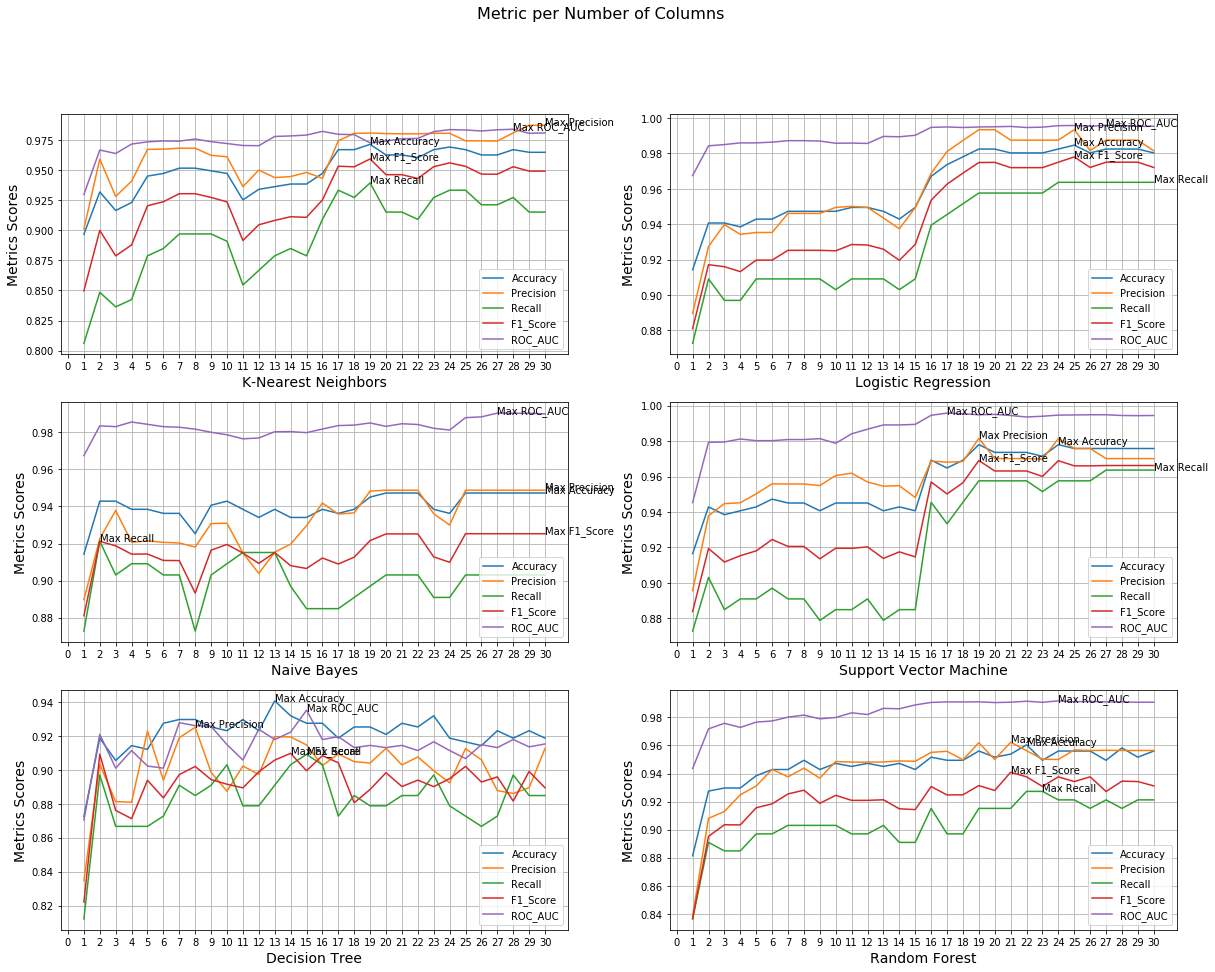

In [49]:
metricScores=['Accuracy','Precision','Recall','F1_Score','ROC_AUC']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
for i, column in enumerate(algorithmsNames):
    i0=i//2
    i1=i%2
    for metric in metricScores:
        metrics[metrics['Algorithm']==column].plot(x='Number_Columns',y=metric,kind='line',grid=True,ax=axes[i0][i1])
        idmax = max(metrics[metrics['Algorithm']==column][metric].index)+1
        x1 = idmax-metrics[metrics['Algorithm']==column][metric].idxmax()
        y1 = metrics[metrics['Algorithm']==column][metric].max()
        axes[i0][i1].text(x1,y1,'Max {}'.format(metric))
    
    axes[i0][i1].set_xlabel(column, size=14)
    axes[i0][i1].set_ylabel('Metrics Scores',size=14) 
    axes[i0][i1].set_xticks(range(31))
    axes[i0][i1].legend(loc = 'lower right')

    
fig.suptitle('Metric per Number of Columns', fontsize=16)
plt.show()

We can see that we reach the highest scores with the algorithms: **K-Nearest Neighbors**,**Logistic Regression** and **Support Vector Machine**. We also can notice an increase in the scores of these algorithms metrics: **Accuracy**, **Precision**, **Recall**, and **F1_Score** at the number of features 16. This indicates that we will be losing valuable information if we choose less than 16 features. Each algorithm has a different optimal point :
- **K-Nearst Neighbors**: The metrics ***Accuracy***, ***F1_Score*** and ***Recall*** reach their highest scores at 19 features, ***ROC_AUC*** at 28 and ***Precision*** at 30.<br>
- **Logistic Regression**: The metrics ***Accuracy***, ***F1_Score*** and ***Precision*** reach their highest scores at 25 features, ***ROC_AUC*** at 27 and ***Recall*** at 30.<br> 
- **Support Vector Machine**: The metric ***ROC_AUC*** reaches its highest score at 17 features, ***F1_Score*** and ***Precision*** reach theirs at 19 features, ***Accuracy*** at 24 and ***Recall*** at 30.  <br> 

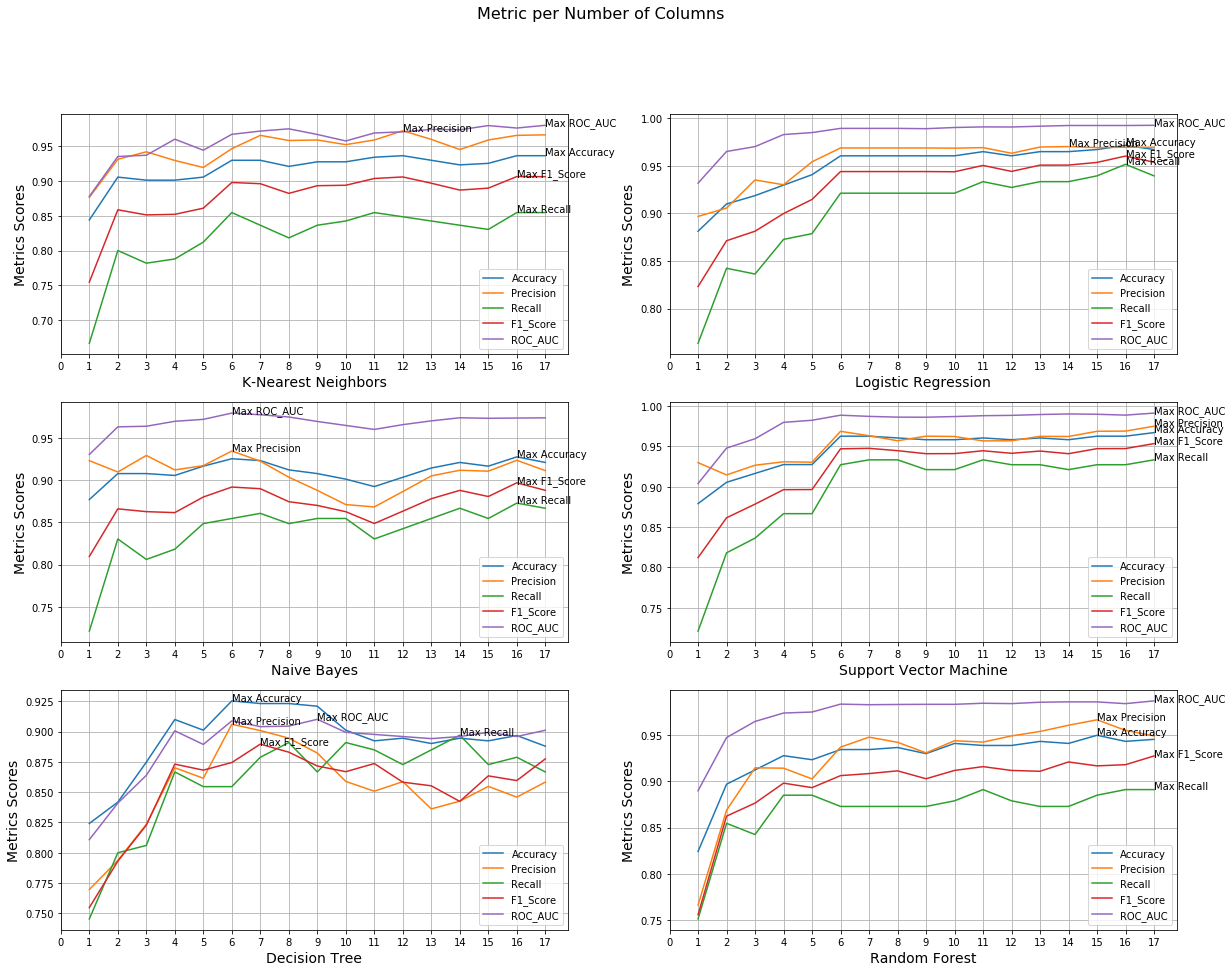

In [50]:
metricScores=['Accuracy','Precision','Recall','F1_Score','ROC_AUC']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
for i, column in enumerate(algorithmsNames):
    i0=i//2
    i1=i%2
    for metric in metricScores:
        metricsNC[metricsNC['Algorithm']==column].plot(x='Number_Columns',y=metric,kind='line',grid=True,ax=axes[i0][i1])
        idmax = max(metricsNC[metricsNC['Algorithm']==column][metric].index)+1
        x1 = idmax-metricsNC[metricsNC['Algorithm']==column][metric].idxmax()
        y1 = metricsNC[metricsNC['Algorithm']==column][metric].max()
        axes[i0][i1].text(x1,y1,'Max {}'.format(metric))
    
    axes[i0][i1].set_xlabel(column, size=14)
    axes[i0][i1].set_ylabel('Metrics Scores',size=14) 
    axes[i0][i1].set_xticks(range(18))
    axes[i0][i1].legend(loc = 'lower right')

    
fig.suptitle('Metric per Number of Columns', fontsize=16)
plt.show()


After eliminating the correlated features, we reach the highest scores with **Logistic regression** and **Support Vector Machine**:
- **Logistic regression**: The metric ***Precision*** reaches its highest score at 14 features,***Accuracy*** and ***F1_Score*** and ***Recall*** reach theirs at 16 features, and ***ROC_AUC*** at 17.  <br> 
- **Support Vector Machine**: All the metrics have the same optimal number of features: 17.<br>

To have a clearer view of which model is the best fit for our problem we will print the highest scores for each metric.

In [51]:
for metric in ['Accuracy','Precision','Recall','F1_Score','ROC_AUC']:
    print('Metric: '+metric)
    print(metrics.loc[metrics[metric].idxmax(),['Algorithm','Number_Columns',metric]])
    print('***')

Metric: Accuracy
Algorithm         Logistic Regression
Number_Columns                     25
Accuracy                     0.984615
Name: 35, dtype: object
***
Metric: Precision
Algorithm         Logistic Regression
Number_Columns                     25
Precision                    0.993333
Name: 35, dtype: object
***
Metric: Recall
Algorithm         Logistic Regression
Number_Columns                     30
Recall                       0.963636
Name: 30, dtype: object
***
Metric: F1_Score
Algorithm         Logistic Regression
Number_Columns                     25
F1_Score                     0.977973
Name: 35, dtype: object
***
Metric: ROC_AUC
Algorithm         Logistic Regression
Number_Columns                     27
ROC_AUC                       0.99582
Name: 33, dtype: object
***


The **Logistic Regression** has the best scores in all the metrics, three of the metrics have the optimal number of features 25. Based on this results the best algorithm to use to predict the *diagnosis* of our test set is **Logistic Regression** with 25 features, eliminating the features: ***fractal_dimension_mean***, ***texture_se***, ***smoothness_se***, ***symmetry_se***, and ***fractal_dimension_se*** that bought **Anova** and **two-sample Z-Test** suggested we eliminate. 

In [52]:
for metric in ['Accuracy','Precision','Recall','F1_Score','ROC_AUC']:
    print('Metric: '+metric)
    print(metricsNC.loc[metricsNC[metric].idxmax(),['Algorithm','Number_Columns',metric]])
    print('***')

Metric: Accuracy
Algorithm         Logistic Regression
Number_Columns                     16
Accuracy                     0.971429
Name: 18, dtype: object
***
Metric: Precision
Algorithm         Support Vector Machine
Number_Columns                        17
Precision                       0.974962
Name: 51, dtype: object
***
Metric: Recall
Algorithm         Logistic Regression
Number_Columns                     16
Recall                       0.951515
Name: 18, dtype: object
***
Metric: F1_Score
Algorithm         Logistic Regression
Number_Columns                     16
F1_Score                     0.960176
Name: 18, dtype: object
***
Metric: ROC_AUC
Algorithm         Logistic Regression
Number_Columns                     17
ROC_AUC                      0.992476
Name: 17, dtype: object
***


The results we obtain after eliminating the correlated features are very close to the complete dataset and with fewer features, for example, the ***ROC_AUC***:
- Initial dataset : **Logistic Regression** with 27 features scored 0.99582.<br>
- Eliminated Correlated features: **Logistic Regression** with 17 features scored 0.992476.<br>

These results suggest that eliminating the correlated features can highly improve the performance of the classification. And it would be interesting to test the outcomes for different coefficient correlation thresholds. For now, we will use the results we obtained with the threshold of 0.85.<br>
Since the results of the Initial dataset is the highest we will use it to predict the *diagnosis*. In the following step, we will train the different algorithms with the 25 features that scored the best with the **Logistic Regression** and analyze the results.

### Final models with the 25 selected features

We will prepare our train and test datasets to keep only the selected features.

In [53]:
indices = sort_indice[:25]
X_train_Selected = X_train_stand[:,indices]
X_test_Selected = X_test_stand[:,indices]

We will train our final models and predict the target variable for our test dataset:

In [54]:
#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_Selected,y_train)
yknn = knn.predict(X_test_Selected)

#Logistic Regression
LR = LogisticRegression(tol = 1e-7, C=1, max_iter=1000)
LR.fit(X_train_Selected,y_train)
yLR = LR.predict(X_test_Selected)

#Naive Bayes 
NB = GaussianNB()
NB.fit(X_train_Selected,y_train)
yNB = NB.predict(X_test_Selected)

#Support Vectors Machine 
svc = SVC(tol = 1e-7, C=1, max_iter=10000)
svc.fit(X_train_Selected,y_train)
ysvc = svc.predict(X_test_Selected)

#Decision Tree 
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train_Selected,y_train)
ytree = tree.predict(X_test_Selected)

#Random Forest 
RF = RandomForestClassifier(criterion='gini',n_estimators=1500)
RF.fit(X_train_Selected,y_train)
yRF = RF.predict(X_test_Selected)

We will compute the classification performance metrics, and store the results in a dataframe called **metrics_evaluation**:

In [55]:
column_names = ['Algorithm','Accuracy','Precision','Recall','F1_Score','ROC_AUC']
metrics_evaluation = pd.DataFrame(columns = column_names)
algorithms=['K-Nearest Neighbors','Logistic Regression',
            'Naive Bayes','Support Vectors Machine',
            'Decision Tree','Random Forest']
y_preds = [yknn,yLR,yNB,ysvc,ytree,yRF]

for (algo, y_pred) in zip(algorithms, y_preds): 
    metrics_evaluation=metrics_evaluation.append(pd.Series([algo,
                                                            accuracy_score(y_test,y_pred),
                                                            precision_score(y_test,y_pred),
                                                            recall_score(y_test,y_pred),
                                                            f1_score(y_test,y_pred),
                                                            roc_auc_score(y_test,y_pred)],
                             index=metrics_evaluation.columns),
                             ignore_index=True)
metrics_evaluation    

Algorithm  Accuracy  Precision    Recall  F1_Score   ROC_AUC
0      K-Nearest Neighbors  0.947368   0.976744  0.893617  0.933333  0.939346
1      Logistic Regression  0.973684   0.978261  0.957447  0.967742  0.971261
2              Naive Bayes  0.912281   0.877551  0.914894  0.895833  0.912671
3  Support Vectors Machine  0.964912   0.957447  0.957447  0.957447  0.963798
4            Decision Tree  0.912281   0.877551  0.914894  0.895833  0.912671
5            Random Forest  0.956140   0.937500  0.957447  0.947368  0.956335

In [57]:
for metric in ['Accuracy','Precision','Recall','F1_Score','ROC_AUC']:
    print('Metric: '+metric)
    print(metrics_evaluation.loc[metrics_evaluation[metric].idxmax(),['Algorithm',metric]])
    print('***')

Metric: Accuracy
Algorithm    Logistic Regression
Accuracy                0.973684
Name: 1, dtype: object
***
Metric: Precision
Algorithm    Logistic Regression
Precision               0.978261
Name: 1, dtype: object
***
Metric: Recall
Algorithm    Logistic Regression
Recall                  0.957447
Name: 1, dtype: object
***
Metric: F1_Score
Algorithm    Logistic Regression
F1_Score                0.967742
Name: 1, dtype: object
***
Metric: ROC_AUC
Algorithm    Logistic Regression
ROC_AUC                 0.971261
Name: 1, dtype: object
***


As expected from the training results, the **Logistic regression** scores the highest. In the **Results** section, we will compute and discuss the confusion matrix for each algorithm.

## Results

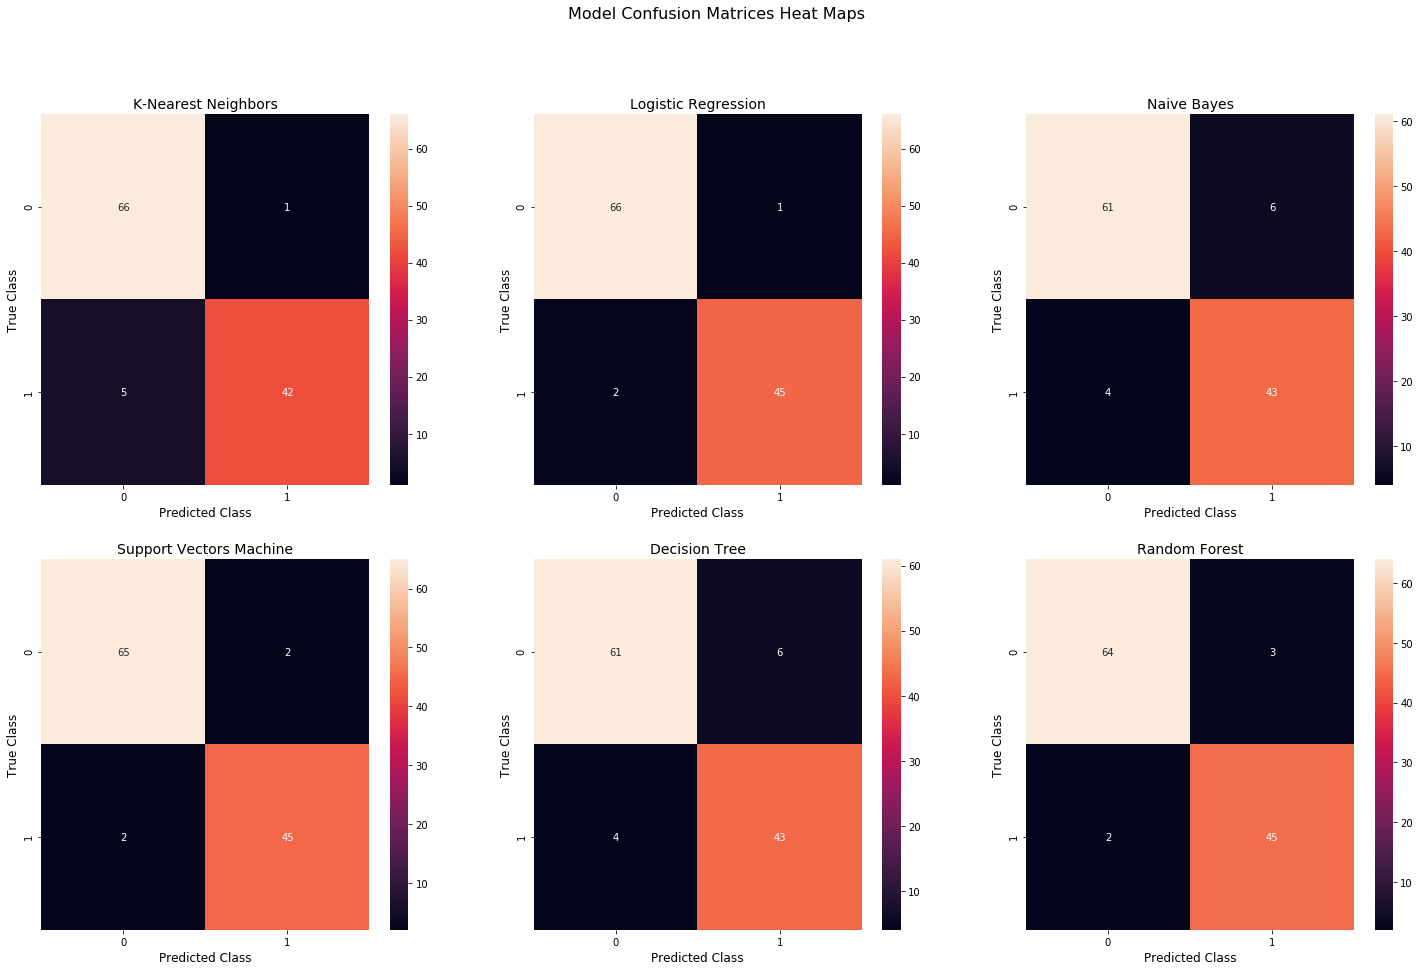

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))

for (i,algo, y_pred) in zip(range(6),algorithms, y_preds): 
    i0=i//3
    i1=i%3
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, ax=axes[i0,i1])
    axes[i0][i1].set_xlabel('Predicted Class', size=12)
    axes[i0][i1].set_ylabel('True Class', size=12)
    axes[i0][i1].set_title(algo, size=14)
fig.suptitle('Model Confusion Matrices Heat Maps', fontsize=16)
plt.show()

The confusion matrices show us the number predicted vs. actual values of the target variable. It allows us to understand better the metrics we computed earlier.<br> The first observation we can make is that the models **K-Nearest Neighbors** and **Logistic Regression** have the lowest *False Positive* value 1, a *Positive* here refers to **Malignant**. This means that :
   - **K-Nearest Neighbors**: Out of the 43  **Malignant** cases, this model predicted, 42 were correct. So this model can predict correctly a **Malignant** tumor with a 97.67 chance.<br>
   - **Logistic Regression** : Out of the 46  **Malignant** cases this model predicted, 45 were correct.So this model can with 97.82 chance predict correctly a **Malignant** tumor.<br>
   
So if ou objective is to minimize the *False Positives*, the two mentioned models are the ones we need to use.<br>

The metric table revealed that the **Logistic regression** scored the highest **recall** value 0.957447. In other words, our model identifies correctly 95.74% of all **malignant** tumors. In our confusion matrix, we can see that out of the 47 true **Malignant** cases our model predicted 45 correctly. This means that **Logistic regression** is the way to go when our intention is to minimize the *False Negatives* <br> 


We can also see that all the models have a decent capability to distinguish between **Malignant** and **Benign** lumps, this can be seen in our confusion matrices in the low values of bought ***False Positives*** and ***False Negatives***, in the worst case we have scored *6 False Positives*. This observation can be confirmed in the high values of the **ROC_AUC** metric scored across all algorithms, ranging from 0.912671 for **Naive Bayes** and **Decision Tree**, to 0.971261 for the **Logistic Regression**. As known, this metric translates the capability a model has to distinguish between classes. In our case, The **Logistic Regression** model was able to distinguish with a 97.13% chance between **Malignant** and **Benign** tumors.<br>

All these results confirm that the **Logistic regression** is the best fit for our problem, as it may be very expensive to allow chances of errors in bought cases:<br>
- Predicting a **Benign** tumor as **Malignant** means allowing the patient to go through an unnecessary and painful medical process and its side effects.<br>
- Predicting a **Malignant** tumor as **Benign** means delaying a necessary treatment and jeopardizing the life of the patient.<br>

## Conclusion

This study allowed us to determin that **Logistic Regression** is the most fitted algorithm for predicting **Breast Cancer**, it was the model that was the most able to distinguish between **Malignant** and **Benign** tumors. We were also able to determin the features with the lowest impact on the diagnosis : ***fractal_dimension_mean***, ***texture_se***, ***smoothness_se***, ***symmetry_se***, and ***fractal_dimension_se***.<br>
The results of our study can be improved through some techniques : 
- In feature Selection using person coefficient correlation:  Use different thresholds.<br>
- Add a feature engineering step in the data preprocessing: Create value bins for the features.<br>

This exercise allowed me to practice more techniques of **Exploratory Data Analysis**, and conquest one of my fears which is **Hypothesis Testing**. 

## Reference

[0]<a name='ref0' href='https://en.wikipedia.org/wiki/Breast_cancer'>https://en.wikipedia.org/wiki/Breast_cancer</a> <br>
[1]<a name='ref1' href='https://www.kaggle.com/uciml/breast-cancer-wisconsin-data'>https://www.kaggle.com/uciml/breast-cancer-wisconsin-data </a> <br>
[2]<a name='ref2' href='https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/'>https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/</a><br>
[3]<a name='ref3' href='https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15'>https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15</a><br>
